In [1]:
import numpy as np
import pandas as pd
import sqlite3
import re

# 1. Inquiry Data Clean

## Load Regulatory Inquiry Data

In [2]:
# Load Regulatory Inquiry Data
regu_inqu = pd.read_excel(
    io="../data/regulatory-inquiry_20230325.xlsx",
    skiprows=1
)
regu_inqu = (
    regu_inqu
    .rename(
        columns = {
            "股票代码": "Stkcd",
            "函件类别": "InquCategory",
            "发函日期": "InquDate",
            "问询内容": "InquContent",
            "限期回复日期": "RespDueDate",
            "公司回复日期": "RespDate",
            "公司回复内容": "RespContent"
        }
    )
    .assign(
        InquDate = lambda x: pd.to_datetime(x.InquDate),
        RespDate = lambda x: pd.to_datetime(x.RespDate),
        InquYear = lambda x: x.InquDate.dt.year)
)
print(f"Find {regu_inqu.shape[0]} inquiries, with {regu_inqu.shape[1]} variables")
regu_inqu.head()

Find 11714 inquiries, with 10 variables


,Stkcd,公司简称,InquCategory,问询标题,InquContent,RespContent,InquDate,RespDueDate,RespDate,InquYear
0,2,万科A,关注函,关于对万科企业股份有限公司的关注函,关于对万科企业股份有限公司的关注函公司部关注函[2016]第142号万科企业股份有限公司董事...,深圳证券交易所公司管理部：万科企业股份有限公司（以下简称“本公司”、“公司”）于2016年8...,2016-08-05,2016/8/9,2016-08-09,2016
1,2,万科A,关注函,关于对万科企业股份有限公司的关注函,关于对万科企业股份有限公司的关注函公司部关注函[2016]第127号万科企业股份有限公司董事...,深圳证券交易所：近日，多家媒体报道称，华润、深铁将溢价收购宝能系所持有的本公司股份，华润、深...,2016-07-08,2016/7/12,2016-07-12,2016
2,2,万科A,许可类重组问询函,关于对万科企业股份有限公司的重组问询函,关于对万科企业股份有限公司的重组问询函许可类重组问询函［2016］第39号万科企业股份有限公...,万科企业股份有限公司关于深圳证券交易所《关于对万科企业股份有限公司的重组问询函》（许可类重组...,2016-06-22,NaN,2016-07-01,2016
3,2,万科A,关注函,关于对华润股份有限公司的关注函,关于对华润股份有限公司的关注函公司部关注函[2016]第120号华润股份有限公司：近日多家媒...,深圳证券交易所：贵所出具的《关于对华润股份有限公司的关注函》（公司部关注函［2016］第12...,2016-06-27,2016/6/29,NaT,2016
4,2,万科A,关注函,关于对深圳市钜盛华股份有限公司通过资产管理计划方式持有万科企业股份有限公司股份事项的关注函,关于对深圳市钜盛华股份有限公司通过资产管理计划方式持有万科企业股份有限公司股份事项的关注函公...,深圳市钜盛华股份有限公司（以下简称“本公司”或“钜盛华”）于2015年12月10日收到贵部《...,2015-12-10,2015/12/14,2015-12-15,2015


## Detect Target Corporates

In [3]:
# Filter Event-Related Inquiries
relevant_inqu = regu_inqu[
    (regu_inqu.InquCategory == "关注函") &
    (regu_inqu.InquContent.str.contains(r"互动易|蹭热|炒作"))
]
print(f"Find {relevant_inqu.shape[0]} inquired corporates \n")

# Detect Patterns of the Inquiry Letters
for _, row in relevant_inqu.sample(n=5).iterrows():
    text = row["InquContent"].replace("\n", "")
    matches = re.findall(r'互动易|蹭热|炒作', text)
    for match in matches:
        print(re.sub(match, f"\033[1;31m{match}\033[0m", text))
    print("\n")

Find 439 inquired corporates 

关于对北京东土科技股份有限公司及其实际控制人李平的关注函创业板关注函【2018】第214号北京东土科技股份有限公司董事会及实际控制人李平：你公司于2017年10月23日披露公司控股股东、实际控制人、董事长李平拟于2017年10月23日起12个月内增持公司股票，增持金额不低于1亿元，累计增持比例不超过本公司已发行股份的2%。2018年9月27日，你公司披露《关于控股股东终止实施增持计划的公告》称，李平于2018年1月31日至2月8日期间增持公司股份2,126,800股，增持资金24,306,342元。由于相关融资增持监管政策变化导致无法筹措增持资金，李平申请终止履行未实施部分的增持计划。上述终止增持计划经董事会审议通过，并将提交股东大会审议。我部对此表示关注。请你公司及李平就以下事项进行核实并说明，并于10月9日前将书面说明材料提交我部。1、李平出具增持计划时，是否就增持资金来源及增持计划的可实现性进行了分析和论证。如是，请说明具体情况；如否，请说明增持计划的披露是否审慎、合规，是否存在通过发布增持计划炒作公司股价的情形。2、《股票质押式回购交易及登记结算业务办法（2018年修订）》于2018年1月份发布，实际控制人9月份才申请终止增持计划。请2补充说明上述间隔期间，实际控制人就保证增持计划的履行所做的工作、实际控制人和公司得知增持计划无法履行的具体时点，是否根据实际情况及时地履行了信息披露义务。3、你公司及李平认为需要说明的其他事项。同时，提醒你公司和李平：上市公司及控股股东、实际控制人必须按照国家法律、法规和《深圳证券交易所创业板股票上市规则》，认真和及时的履行信息披露义务。上市公司的董事会全体成员必须保证信息披露内容真实、准确、完整，没有虚假、严重误导性陈述或重大遗漏，并就其保证承担个别和连带的责任。特此函告。创业板公司管理部2018年9月28日


关于对湖北共同药业股份有限公司的关注函创业板关注函〔2021〕第217号湖北共同药业股份有限公司董事会：你公司股票价格近期波动较大，2021年4月26日至4月30日累计上涨94.03%，与同期创业板综指偏离度较大，期间两次触及异常波动标准。我部对此表示关注，请你公司进一步核实并说明以下事项：1.请结合市场宏观情况、行业情况、同行业上市公司股价走势，及公司

In [4]:
# Filter Event-Related Corporates
relevant_inqu_corp = (
    relevant_inqu[["Stkcd", "InquYear", "InquDate"]]
    .drop_duplicates(keep="first")
    .assign(
        Stkcd = lambda x: x.Stkcd.astype(str).str.zfill(6),
        PrevYear = lambda x: x.InquYear - 1
    )
)
print(f"Find {relevant_inqu_corp.shape[0]} event-related corporates\n")
print(relevant_inqu_corp.groupby("InquYear").count())
relevant_inqu_corp.sample(frac=0.1)

Find 434 event-related corporates

          Stkcd  InquDate  PrevYear
InquYear                           
2016          5         5         5
2017          5         5         5
2018         44        44        44
2019         93        93        93
2020        148       148       148
2021        139       139       139


,Stkcd,InquYear,InquDate,PrevYear
8082,300354,2021,2021-07-13,2020
5935,300031,2020,2020-07-31,2019
9023,300645,2018,2018-11-16,2017
8450,300436,2020,2020-04-17,2019
6553,300109,2021,2021-12-14,2020
1786,000829,2021,2021-09-12,2020
8276,300393,2021,2021-07-01,2020
1232,000676,2021,2021-02-05,2020
7300,300225,2020,2020-11-04,2019
4282,002488,2020,2020-03-11,2019


In [5]:
from pyecharts import options as opts
from pyecharts.charts import Bar

grouped = relevant_inqu_corp.groupby("InquYear").count()

bar_chart = Bar()
bar_chart.add_xaxis(grouped.index.tolist())
bar_chart.add_yaxis('Value', grouped["Stkcd"].tolist())

bar_chart.set_global_opts(
    xaxis_opts=opts.AxisOpts(name='Year'),
    yaxis_opts=opts.AxisOpts(name='Value'),
    title_opts=opts.TitleOpts(title='Yearly Distribution')
)

bar_chart.render_notebook()

# 2. Motivation Analysis

## Financial Analysis

In [6]:
# Load Financial Report Data
con_fin = sqlite3.connect(
    database="../../Data-for-Accounting-Research/accounting_data.sqlite"
)
basic_vari = pd.read_sql_query(
    sql="SELECT Stkcd, Year, Loss, ROE, Size, Lev, Growth, Big4 FROM common_variables WHERE Year >= 2015",
    con=con_fin
)
basic_vari.head()

,Stkcd,Year,Loss,ROE,Size,Lev,Growth,Big4
0,000001,2015.0,0.0,0.135387,28.550167,0.935584,0.312414,1.0
1,000001,2016.0,0.0,0.111782,28.713990,0.931547,0.126325,1.0
2,000001,2017.0,0.0,0.104430,28.809206,0.931644,0.004338,1.0
3,000001,2018.0,0.0,0.103390,28.860250,0.929783,0.012806,1.0
4,000001,2019.0,0.0,0.090085,29.001966,0.920544,0.193971,1.0


In [7]:
# Merge Financial Data with Inquired Corporations
merge_res = (
    pd.merge(
        left=relevant_inqu_corp,
        right=basic_vari,
        how="outer",
        left_on=["Stkcd", "PrevYear"],
        right_on=["Stkcd", "Year"],
        indicator=True
    )
    .drop(["InquYear", "PrevYear"], axis=1)
    .query("_merge != 'left_only'")
)
merge_res["Year"] = merge_res["Year"].map(str)

print(merge_res.groupby("_merge").count())
merge_res.sample(n=5)

            Stkcd  InquDate   Year   Loss    ROE   Size    Lev  Growth   Big4
_merge                                                                       
left_only       0         0      0      0      0      0      0       0      0
right_only  25212         0  25212  25212  25212  25212  25212   23131  25190
both          426       426    426    426    426    426    426     392    426


,Stkcd,InquDate,Year,Loss,ROE,Size,Lev,Growth,Big4,_merge
11893,300302,NaT,2021.0,1.0,-0.008041,21.317672,0.171055,0.179076,0.0,right_only
9577,002913,NaT,2018.0,0.0,0.109880,21.861346,0.303357,0.287092,0.0,right_only
19926,600837,NaT,2018.0,0.0,0.044327,27.076981,0.773441,0.086415,0.0,right_only
19084,600706,NaT,2016.0,0.0,0.058366,21.299703,0.501397,0.059664,0.0,right_only
6705,002450,NaT,2018.0,1.0,-2.306663,23.525384,0.938062,0.064659,0.0,right_only


In [8]:
# Calculate Differences between the Inquired and Common Corporates
merge_res["Growth"] = merge_res["Growth"].fillna(0)
merge_res.groupby("_merge").mean(numeric_only=True).iloc[1:3, :]

,Loss,ROE,Size,Lev,Growth,Big4
_merge,,,,,,
right_only,0.118198,-0.015416,22.329552,0.426687,NaN,0.069948
both,0.241784,-0.186570,21.592593,0.386033,0.091692,0.004695


## High Reduction

In [9]:
manager_hold = pd.read_csv("../data/manage-hold-change.csv")
manager_hold = (
    manager_hold
    .rename(columns={
        "Sthcnme": "Manager",
        "Scdate": "ChangeDate",
        "Qostc": "ChangeVolume"
    })
    .assign(
        Stkcd = lambda x: x.Stkcd.astype(str).str.zfill(6),
        ChangeDate = lambda x: pd.to_datetime(x.ChangeDate)
    )
    .drop(["Stknme"], axis=1)
)

relevant_hold_change = (
    pd.merge(
        left=relevant_inqu_corp.loc[:, ["Stkcd", "InquDate"]],
        right=manager_hold,
        on="Stkcd"
    )
    .assign(
        StartDate = lambda x: x.InquDate - pd.Timedelta("45 days"),
        EndDate = lambda x: x.InquDate + pd.Timedelta("15 days")
    )
    .query(
        "ChangeDate >= StartDate & ChangeDate <= EndDate"
    )
)
print(relevant_hold_change.shape)
hold_change_count = relevant_hold_change.groupby("Stkcd")["ChangeVolume"].sum().to_numpy()
hold_change_direction = np.where(hold_change_count > 0, "Increase", "Decrease")
hold_change = pd.DataFrame({"Count": hold_change_count, "Direction": hold_change_direction})
print(hold_change.groupby("Direction").sum())
print(hold_change.groupby("Direction").count())
hold_change["Count"] = hold_change["Count"].abs()
hold_change

(461, 7)
                 Count
Direction             
Decrease  -228187297.0
Increase    37943507.0
           Count
Direction       
Decrease      79
Increase      25


,Count,Direction
0,100.0,Decrease
1,7800.0,Decrease
2,136100.0,Decrease
3,100.0,Increase
4,320000.0,Increase
...,...,...
99,865100.0,Increase
100,5615000.0,Decrease
101,1637900.0,Increase
102,1000.0,Increase


In [10]:
from pyecharts.charts import Pie

data_grouped = hold_change.groupby('Direction')['Count'].sum().reset_index()
pie_data = [(row['Direction'], row['Count']) for _, row in data_grouped.iterrows()]

pie_chart = (
    Pie()
    .add('', pie_data)
    .set_colors(['#87CEFA', '#FFC0CB'])
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    .set_global_opts(title_opts=opts.TitleOpts(title="Direction Distribution"))
)

pie_chart.render_notebook()

## Innovation Influence

In [11]:
patent_grant = pd.read_excel("../data/patent-grant.xlsx", skiprows=1)
patent_grant = (
    patent_grant
    .rename(
        columns={"股票代码": "Stkcd", "会计年度": "Year"}
    )
    .assign(
        Stkcd = lambda x: x.Stkcd.astype(str).str.zfill(6),
        PatentCount1 = lambda x: x.当年独立申请的发明数量,
        PatentCount2 = lambda x: x.当年独立申请的实用新型数量,
        PatentCount3 = lambda x: x.当年独立申请的发明数量 + x.当年独立申请的实用新型数量
    )
    .query(
        "公司类型 == '集团公司合计' & Year >= 2016"
    )
    .loc[:, ["Stkcd", "Year", "PatentCount1", "PatentCount2", "PatentCount3"]]
)

pd.merge(
    left=relevant_inqu_corp.loc[:, ["Stkcd", "InquYear"]],
    right=patent_grant,
    left_on=["Stkcd", "InquYear"],
    right_on=["Stkcd", "Year"],
    how="outer",
    indicator=True
).drop(["InquYear"], axis=1).groupby("_merge")["PatentCount1", "PatentCount2", "PatentCount3"].mean()

<ipython-input-11-cd600b15ebdd>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pd.merge(


,PatentCount1,PatentCount2,PatentCount3
_merge,,,
left_only,NaN,NaN,NaN
right_only,33.593159,30.485654,64.078813
both,15.018476,15.505774,30.524249


# 3. Textural Pattern Detection

## Load HuDongE Posts Data

In [12]:
# Load HuDongE Posts Data
hde_posts = pd.read_parquet("../data/HuDongE/")
print(f"Get {hde_posts.shape[0]} posts")

hde_posts = hde_posts.rename(
    columns = {
        "股票代码": "Stkcd",
        "提问时间": "QuesTime",
        "提问内容": "QuesContent",
        "回复时间": "RespTime",
        "回复内容": "RespContent",
        "上市公司是否回复": "IsResp",
        "Year": "QuesYear"
    }
)
print(hde_posts.groupby("QuesYear")[["QuesContent", "RespContent"]].count())
hde_posts.sample(n=5)

Get 4442553 posts
          QuesContent  RespContent
QuesYear                          
2010            18880        17563
2011            61445        59425
2012           146846       142310
2013           338899       327879
2014           513105       494322
2015           569910       534676
2016           452179       426913
2017           430675       401832
2018           355033       323714
2019           306270       281716
2020           503777       466548
2021           557291       515001
2022           188242       187463


,数据来源,Stkcd,公司简称,浏览用户/注册用户,用户名,QuesTime,QuesContent,IsResp,RespTime,RespContent,字数1,字数2,QuesYear
3168670,深交所互动易,300715,凯伦股份,注册用户,Jwill777,2019-09-20 17:15:48,你好请问截至9月20日公司股东人数是多少？谢谢,已回复,2019-09-23 16:53:54,"您好，感谢您对公司的关注，截止2019年9月20日，公司股东户数为6,821户。",35,40,2019
116823,深交所互动易,002038,双鹭药业,注册用户,张列,2012-01-20 21:47:01,"想问一下董事、高管王勇波和席文英在2011年最后一个交易日的卖出原因,因为短期卖点很精准,如...",已回复,2012-01-30 16:18:22,您好，股价波动涉及多方面因素，去年年底公司部分高管的减持完全系个人行为。之前已有高管就前期敏...,140,150,2012
4298805,深交所互动易,002349,精华制药,注册用户,cninfo932081,2022-02-10 17:13,董秘您好，请问公司去年12月至今有接到过小额订单吗,已回复,2022-02-14 16:54,公司处于正常生产销售，感谢您对公司的关心！,19,21,2022
2259629,深交所互动易,002414,高德红外,浏览用户,浏览用户4869,2017-06-09 08:23:13,请问能在以下几个专业方面为投资者解读一下“一元红外芯”的里程碑意义么：\n1、“一元红外芯”...,已回复,2017-06-09 19:46:46,公司“一元红外芯”是公司此次参加北京光博会首发新品，是一款单片式红外机芯，集成度高，平台开放...,76,86,2017
1611564,上证e互动,600237,铜峰电子,注册用户,LLAN110,2015-07-06 08:43,在上海成立的投资公司，上半年都做了什么事情？,已回复,2016-05-11 15:41,公司在上海设立的全资子公司-----上海裕溪投资有限公司已完成注册工作，谢谢！,32,39,2015


In [13]:
hot_events = pd.read_excel("../data/hot-events_20230325.xlsx")
hot_events = set(hot_events.Event.to_list())
hot_events_expr = "|".join(hot_events)
print(hot_events_expr)

特斯拉|ETC|6G|地摊|鸿蒙|人造肉|Mate30|专精特新|流浪地球|数字货币|PVDF|北斗|双十一|TWS|碳中和|元宇宙|阿兹夫定|透明工厂|储能|千金藤素|5G|新基建|芯片|工业大麻|边缘计算|可燃冰|光刻胶|免税|OLED|呼吸机|胎压监测|在线办公|垃圾分类|辉瑞|口罩|区块链|工业母机|雄安|RCS|东数西算|量子通信


In [14]:
relevant_posts = (
    pd.merge(
        left=relevant_inqu_corp.loc[:, ["Stkcd", "InquDate"]],
        right=hde_posts,
        how="left",
        on="Stkcd"
    )
    .assign(
        QuesTime = lambda x: pd.to_datetime(x.QuesTime),
        RespTime = lambda x: pd.to_datetime(x.RespTime),
        StartDate = lambda x: x.InquDate - pd.Timedelta("30 days")
    )
    .query(
        "QuesTime >= StartDate & QuesTime < InquDate & IsResp == '已回复'"
    )
)
print(relevant_posts.shape[0])

relevant_posts = relevant_posts[
    relevant_posts.QuesContent.str.contains(hot_events_expr) |
    relevant_posts.RespContent.str.contains(hot_events_expr)
]

que_expr = "有[没无] | [能可是][否不] | 哪些 | 什么 | [(披露)(介绍)(了解)] | 多[大少] | 如何 | [?？问吗么]". \
    replace(" ", "")
que_idx = relevant_posts["QuesContent"].str.contains(que_expr)
res_expr = "未(?![来经]) | 不[涉生包是存属含会从(确定)] | 暂(?!停) | 没有 | [很较]小 | 无(?![疑线尘损人害法纺限]) | 建议". \
    replace(" ", "")
res_idx = relevant_posts["RespContent"].str.contains(que_expr)

relevant_posts = relevant_posts[
    que_idx & ~res_idx
]

print(relevant_posts.shape[0])

for _, row in relevant_posts.sample(5).iterrows():
    tip = f" {row['Stkcd']} | {row['QuesTime']} "
    print(f"{tip:-^60}")
    print(f"Question: {row['QuesContent']}")
    print(f"Response: {row['RespContent']}")
    print()

7305
758
--------------- 300340 | 2020-03-04 17:54:03 ---------------
Question: 浩能科技推出n95平面口罩机全自动生产线吗？
Response: 补充提示：根据截至目前浩能科技已收到的口罩生产设备订单，预计口罩设备业务不会对公司2020年业绩产生重大影响，请投资者注意投资风险，谢谢。

--------------- 300829 | 2020-05-28 14:34:45 ---------------
Question: 公司产品可以用于光刻胶领域么
Response: 乳酸乙酯可作为有机溶剂可用于半导体材料的清洗。目前公司乳酸乙酯的销售主要通过外采方式满足客户需求，下游客户主要为光伏、电子行业企业。

--------------- 300364 | 2021-11-10 13:24:21 ---------------
Question: 董秘好，三体的世界观非常宏大，获得了雨果奖，全世界的知名度很高，是否有计划和想法基于元宇宙开发该ip？
Response: 尊敬的投资者，您好：公司跟作家刘慈欣有合作，公司拥有《流浪地球》、《乡村教师》、《朝闻道》、《吞食者》、《中国太阳》、《微纪元》、《地球大炮》、《白垩纪往事》等29部作品的数字版权。同时拥有《流浪地球》和《乡村教师》的全球、全语种独家游戏改编权，《乡村教师》改编的沉浸式互动阅读已在chapters上线。

--------------- 300184 | 2021-10-11 14:40:12 ---------------
Question: 请问，贵公司在互动平台中提示公司完成第一颗芯片产品的客户测试，还有第二课芯片在流片，请问目前产品出来了吗？谢谢！
Response: 公司第二款M0+芯片目前已完成芯片制造环节的工艺流程，正在封装样片；第三款产品已快完成流片的光罩环节，预计十二中旬可以拿到样片；第四款产品正在开始流片的光罩工艺。谢谢！

--------------- 300343 | 2021-07-12 13:24:52 ---------------
Question: 请问董秘，市场对PVDF需求量大增，价格也节节攀升，贵公司年产8000吨PVDF项目下半年能投产吗？是否能抓住这次机遇？
Response:

## NLP Analysis

In [15]:
from transformers import BertTokenizer, BertModel
import torch
from torch.nn.functional import cosine_similarity

In [16]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = BertTokenizer.from_pretrained('shibing624/text2vec-base-chinese')
model = BertModel.from_pretrained('shibing624/text2vec-base-chinese')

In [17]:
def calcu_similarity(input_sentences, verbose=True):
    encoded_input = tokenizer(list(input_sentences), padding=True, truncation=True, max_length=256, return_tensors='pt')
    # Compute token embeddings
    try:
        with torch.no_grad():
            output = model(**encoded_input)
    except RuntimeError:
        print("ERROR !!!")
        print(f"Question: {input_sentences[0]}")
        print(f"Response: {input_sentences[1]}")
        print()
        return pd.NA
    # Perform pooling. In this case, mean pooling.
    sentence_embeddings = mean_pooling(output, encoded_input['attention_mask'])
    simi_value = cosine_similarity(sentence_embeddings[0], sentence_embeddings[1], dim=0)

    if verbose:
        print("-" * 60)
        print(f"Question: {input_sentences[0]}")
        print(f"Response: {input_sentences[1]}")
        print(f"Sentence Similarity: {simi_value.item():.3f}")
        print()
    return simi_value.item()

In [18]:
simi_res, len_res = [], []
for sentences in zip(relevant_posts['QuesContent'], relevant_posts['RespContent']):
    len_res.append(len(sentences[1]) / len(sentences[0]))
    simi_res.append(calcu_similarity(sentences))

------------------------------------------------------------
Question: 尊敬的董秘您好，作为公司的小股东，请问公司研究的无菌口罩在满足了国内的需求后，是否准备出口日本？
Response: 您好，公司本次消毒灭菌口罩生产业务开展顺应子公司零度大健康的业务发展及多元化需求，目前口罩生产设备尚在等待厂商交付，如后续交付及承揽工作正常开展实现量产，公司将先完成前期捐赠安排，再根据届时市场实际情况决定销售途径，不排除出口的可能性。请以公司公告为准，同时注意投资风险。感谢您的关注！
Sentence Similarity: 0.751

------------------------------------------------------------
Question: 您好，生产口罩设备何时到货？何时安装？何时生产？
Response: 您好，口罩设备尚在合同约定交付期内，后续交付及生产情况请以公司公告为准，同时注意投资风险。谢谢！
Sentence Similarity: 0.740

------------------------------------------------------------
Question: 请问康芯威存储首批10万颗存储器控制器芯片的出货对象是否为长江存储？
Response: 你好，谢谢你的关注。
Sentence Similarity: 0.440

------------------------------------------------------------
Question: 请问芯片的大概售价能不能透露一下，谢谢
Response: 你好，谢谢你的关注。
Sentence Similarity: 0.440

------------------------------------------------------------
Question: 请问董秘：除了已经销售的存储控制芯片外，有哪些其它在研芯片？既定方向在哪些领域？
感谢您的回复！！！
Response: 你好，谢谢你的关注。关于本公司在半导体领域的布局请您关注本公司的定期报告及相关临时公告。
Sentence Similarity: 0.666

---------------

------------------------------------------------------------
Question: 据报道：“现有的通信设备离不开FPGA，美国制裁相关中企，FPGA也位列制裁名单之上，而华为和中兴所需的FPGA大多依赖于从赛灵思、阿尔特拉等美国公司进口。”建议公司引进华为作为战略股东，大规模国产替代供应华为稀缺所需的FPGA芯片、GPU芯片、5G射频芯片，实现互盈互利大发展！此合理化建议能否接受，敬请公司董事会回答！
Response: 尊敬的投资者，公司会积极进取、持续不断投入研发、推进公司的FPGA芯片在民用通信设备上应用验证工作；现阶段，这款芯片的应用领域仍集中在军用武器装备配套。非常感谢您对公司的关注和建议。
Sentence Similarity: 0.817

------------------------------------------------------------
Question: 新闻报道：航锦科技全资子公司长沙韶光独家生产的可编程逻辑门阵列（万能芯片）FPGA芯片已大批量生产，并且供不应求，请问情况是否属实？敬请公司领导回答！
Response: 尊敬的投资者，公司的特种FPGA产品已进入量产阶段，其在武器装备控制系统上的应用已经过多方专家和事实检验。公司会高效利用产能，按时、及时、高质量地为武器装备的采购订单供应。感谢您的关注。
Sentence Similarity: 0.717

------------------------------------------------------------
Question: 近期长沙韶光的订单不时有公告，独缺深圳威科的订单公告，请问威科什么时候能和特斯拉（上海）或上海大众等实力车企开展合作，即汽车电子的订单今年何时能出现？另，威科与华为的通讯订单到底有没有，何时能有，有没有专人推进？有本事春节后公告一二啊！一句话，只有拓宽民用订单，818才会走的长远和长久，市场对民用这块的产品已等了很久了，着急……
Response: 尊敬的投资者，威科电子的厚膜基础电路在汽车电子领域已有应用。公司会认真考虑您的建议，感谢您对公司的关注。
Sentence Similarity: 0.614

------------------------------

------------------------------------------------------------
Question: 你们的工业大麻到底是不是蹭热点，如果不是，为什么这么久了一点进展都没有？
Response: 尊敬的投资者朋友，感谢您对公司的关注及支持。公司工业大麻产业发展项目正在推进当中，谢谢！
Sentence Similarity: 0.603

------------------------------------------------------------
Question: 公司工业大麻项目自打6月6日公告成立项目公司文麻生物后再无下文了，四个月过去了，现在进展到了哪步了，50万亩的种植面积的所需土地是否已经落实？既然公司立志投身于工业大麻全产业链发展，那就尽快落实，不要去蹭热点，然后再无下文了
Response: 尊敬的投资者朋友，感谢您对公司的关注及支持。公司工业大麻产业发展项目正在推进当中，谢谢！
Sentence Similarity: 0.658

------------------------------------------------------------
Question: 9月4日，ImpossibleFoods创始人兼首席执行官帕特里克?布朗（PatrickO,Brown）在云南省玉溪市出席2019年财富全球可持续论坛时表示，未来一年将努力发展中国内地市场，希望与潜在合作伙伴在中国内地种植、生产、销售植物型人造肉产品。请问董秘，文麻生物是否参加了云南2019年财富可持续论坛？公司是否会跟BEYONGMEAT公司或IMPOSSIBLEFOODS公司合作？
Response: 尊敬的投资者朋友，感谢您对公司的关注及支持。谢谢！
Sentence Similarity: 0.222

------------------------------------------------------------
Question: 请问公司有人造肉产品的研发吗？谢谢回复！
Response: 尊敬的投资者朋友，感谢您对公司的关注及支持！人造肉是美盈森集团工业大麻产业发展项目发展的方向之一，谢谢！
Sentence Similarity: 0.741

-----------------------------

------------------------------------------------------------
Question: 董秘你好,贵司有没有收到来自日本或其他国家的口罩订单?今天中午新闻说日本口罩供应严重不足需要向中国进口口罩,美国的口罩也只有4周的库存量,现在国际上都是口罩紧缺,或者说贵司参股的跨境电商公司拉拉米有没有收到国外的口罩订单?
Response: 公司全资子公司东莞市搜于特医疗用品有限公司口罩生产目前正在全力筹备，口罩出口认证工作也在积极推进中，预计三月中上旬可以投入生产。
Sentence Similarity: 0.670

------------------------------------------------------------
Question: 董秘你好,自贵司2月11日发布公告生产销售医用口罩、防护服等医疗用品后,贵司各大线上的网红粉丝量是否几何级暴增?现在网上是有口罩卖就有人气.
Response: 公司目前口罩及防护服的生产还在筹备阶段，暂未在网上销售，后期产品正式投入市场后会利用好线上销售平台。
Sentence Similarity: 0.700

------------------------------------------------------------
Question: 新冠病毒逐渐在国内得到控制，却在全世界范围内开始爆发流行，请问公司口罩是否能够在保证国内需求的同时，开辟世界市场？？？
Response: 公司全资子公司东莞市搜于特医疗用品有限公司口罩生产目前正在全力筹备，口罩出口认证工作也在积极推进中，预计三月中上旬可以投入生产。
Sentence Similarity: 0.702

------------------------------------------------------------
Question: 请问公司还生产熔喷布吗？
Response: 公司全资子公司东莞市搜于特医疗用品有限公司的经营范围含有熔喷布的生产销售。目前公司会积极推进医疗口罩及防护服的生产销售。
Sentence Similarity: 0.588

------------------------------------------------------------
Quest

------------------------------------------------------------
Question: 公司未来想有打进特斯拉和比亚迪车厂供应商的计划吗？
Response: 公司一直在持续进行产品开发和市场开拓，积极拓展新客户，谢谢！
Sentence Similarity: 0.577

------------------------------------------------------------
Question: 你好,经传闻,公司与特斯拉进行洽谈,是否近期与特斯拉有合作?
Response: 公司与特斯拉目前暂无业务往来，谢谢！
Sentence Similarity: 0.678

------------------------------------------------------------
Question: 贵公司的热管理类产品有无应用于储能方面的？
Response: 公司研发生产的低温散热器是应用于新能源汽车电池热管理系统，谢谢！
Sentence Similarity: 0.768

------------------------------------------------------------
Question: 请问懂秘,贵公司有相关储能方面的产品或者技术么?
Response: 公司主要从事汽车热管理系统散热器、油冷器、中冷器、冷凝器、暖风机等换热器产品以及保险杠等车身结构件产品的研发、生产和销售，谢谢！
Sentence Similarity: 0.636

------------------------------------------------------------
Question: 董秘，你好，请问为什么不把钱花在每个大学的超材料的学科建设、理论研究上，不花在超材料芯片研发上，不花在国内，反而现在疫情期间到国外并购呢，是因为超便宜吗，还是性价比超高呢，谢谢！
Response: 感谢您对公司的关注和建议。公司持续保持高比例的研发投入，推动技术创新，为后续发展打下基础。海外并购项目已经中止。
Sentence Similarity: 0.617

--------------------------------------------------------

------------------------------------------------------------
Question: 华为、三星、小米都发布折叠手机，请问公司是否有AMOLED相关的技术储备？目前研发情况如何？华为是否是公司的客户。
Response: 您好！公司拥有AMOLED相关技术储备，目前研发技术条件成熟。华为系公司的重要客户之一，双方保持着长期良好的战略合作关系。谢谢！
Sentence Similarity: 0.684

------------------------------------------------------------
Question: 华为即将发布首款5G柔面屏手机，请问华为是公司客户吗？
Response: 您好！华为系公司的重要客户之一，双方保持着长期良好的战略合作关系。谢谢！
Sentence Similarity: 0.532

------------------------------------------------------------
Question: 观察到公司在报表中说明，在触控显示产品方面，公司将会着重开发PMOELD，AMOLED，且此前公司收购的博一光电有OLED业务，请问贵公司OLED业务目前发展状况如何？有怎样的成果？是否与三星、华为、小米等有合作关系？在OLED柔性屏上有没有布局的打算？
Response: 您好！公司OLED业务发展顺利，技术条件成熟。公司和品牌客户正在紧密接触。公司已经具备柔性屏的生产能力。谢谢！
Sentence Similarity: 0.831

------------------------------------------------------------
Question: 电影流浪地球中的高科技人工智能MOSS莫斯，具有强大的计算力，可以帮助人类解决执行众多任务！贵公司股价最近连续暴涨！是否也有生产销售这种人工智能MOSS产品？
Response: 您好！公司主要从事微特电机、触摸显示产品以及结构件产品的研发、生产及销售。谢谢！
Sentence Similarity: 0.613

------------------------------------------------------------
Question: 

------------------------------------------------------------
Question: 董秘您好；
请问公司的游戏酿酒大师如何通过做到手游可以有沉浸式体验的？因为手机是2D的图形，但是元宇宙是VR，AR ,5G,NFT等技术的融合，说以比较困惑
Response: 尊敬的投资者您好，《酿酒大师》遵循元宇宙设定，基于现实构造拟真还原平行空间，根据现实社会良俗和法律法规，为用户开放高自由度、高创造度的虚拟空间，将现实和虚拟深度绑定结合。依托于“金沙古酒”和公司的强强联合，真实做到虚拟与现实联合。产品一共分为 H5、2D、3D、VR等多个版本，逐步搭建，逐渐实现虚拟与现实交互的体系。用户在虚拟空间中，可以拥有属于自己的土地和产业，全拟真化经营，从原料的采购、产品的制造、酒品的调勾、包装的设计、销售链路的铺设全部交由用户自己来打造和处理。感谢您的关注。
Sentence Similarity: 0.833

------------------------------------------------------------
Question: 请问公司新研发的“家有小镇”游戏是元宇宙的区块链游戏吗？关于此游戏的信息比较少，麻烦具体介绍一下
Response: 尊敬的投资者您好，公司目前没有开发“家有小镇”这款游戏。感谢您的关注。
Sentence Similarity: 0.716

------------------------------------------------------------
Question: 董秘你好，万亿巨头FACEBOOK宣布转型元宇宙，公司是否应该抓住这个机遇个潮流，抓紧《酿酒大师》的上线，预计多久能上线？
Response: 尊敬的投资者您好，该游戏的上线时间请以公司公告为准。感谢您的关注。
Sentence Similarity: 0.451

------------------------------------------------------------
Question: 请问董秘，公司有向元宇宙领域发展的打算吗？谢谢
Response: 尊敬的投资者您好，中青宝公司以坚持打造中国最优秀的民族网游为理念，做好红色文化的传承者，打造中国红色游戏第一品牌，传统红色游戏

------------------------------------------------------------
Question: 请问公司与投资区块链创企skuchain在哪些方面有合作？
Response: 您好，暂无具体的业务合作。感谢关注。
Sentence Similarity: 0.474

------------------------------------------------------------
Question: 公司在区块链产业方面有哪些布局了？
Response: 您好，公司所投资的基金AminoCapita，在美国硅谷以投区块链为主，Amino的投资案例包括DFINITY，Oasis，OmiseGO，及Skuchain等项目。尚且对公司经营和财务不构成重大影响，请您注意投资风险。感谢关注。
Sentence Similarity: 0.711

------------------------------------------------------------
Question: 公司去年曾在前程无忧网发布招聘公告，招聘：区块链高级研发工程师。招聘职位要求为：主要负责基于区块链（blockchain）的票据系统和金融产品的设计和研发。请问公司的票据系统和相关金融产品是否有区块链的应用，能否就应用于公司及广电密码保护等的各项商用业务上？
Response: 您好，公司目前对相关人员的安排符合公司需求，基于公司的经营情况与发展战略需要，区块链研发小组主要针对区块链与版权保护技术结合的探索研究。目前无商用，对公司经营和财务尚不构成重大影响，请注意投资风险。感谢关注。
Sentence Similarity: 0.810

------------------------------------------------------------
Question: 公司去年曾在前程无忧网发布招聘公告，招聘：区块链高级研发工程师。招聘职位要求为：主要负责基于区块链（blockchain）的票据系统和金融产品的设计和研发。请问公司的人员招聘是否已经到位，目前开展了哪些工作？
Response: 您好，公司目前对相关人员的安排符合公司需求，基于公司的经营情况与发展战略需要，区块链研发小组主要针对区块链与版权保护技术结合的探索研究。对

------------------------------------------------------------
Question: 董秘您好，贵收购先锋微电子之后，有没有开始跟国内汽车品牌接洽，提供芯片支持？
Response: 尊敬的投资者，您好！完成收购日本先锋微电子后，公司发挥销售渠道优势，帮助其扩展国内产品市场，目前英唐微技术已有部分产品在国内处于研发评估及样品测试阶段。感谢您的关注。
Sentence Similarity: 0.755

------------------------------------------------------------
Question: 请问公司作为华为核心供应商，哪些产品进入了华为5G供应链？公司基站和滤波器产品情况如何？谢谢
Response: 感谢您的关注，公司是华为长期合作的核心供应商，持续向华为提供通信基站的核心产品，包括5G滤波器等。
Sentence Similarity: 0.854

------------------------------------------------------------
Question: 请问公司有fbarfilter产品吗
Response: 感谢您的关注，公司主营业务是移动通信基站射频产品、智能终端产品、汽车零部件的研发、生产和销售。其中，移动通信基站射频产品包括射频器件、射频结构件等移动通信系统的核心部件，产品主要应用于2G~5G全系列移动通信系统。
Sentence Similarity: 0.534

------------------------------------------------------------
Question: 请问公司的射频滤波器产品目前是否已经供应华为，今年是否已经获得华为订单？另外公司在终止和重庆百立丰的重组以后承诺一个月内不再筹划重大事项，未来重组方向会围绕通信主业进行，但是在2018年公司减亏中安徽国资和蚌埠城投给予公司帮助很大，公司会不会与安徽国资旗下资产进行重组？
Response: 感谢您的关注，公司是华为长期合作的核心供应商，持续向华为提供通信基站的核心产品，包括4G/5G滤波器等。重组相关事项请以公司公告信息为准。
Sentence Similarity: 0.749

-----------

------------------------------------------------------------
Question: 董秘您好！贵公司互动平台回复问题很及时，董秘辛苦，非常感谢，祝您新年快乐！希望剥离教育资产，专注主业的秀强股份2020年业绩越来越好，早日在特斯拉光伏瓦片玻璃拿到大订单！
Response: 您好，谢谢对公司发展的关注。祝春节快乐！
Sentence Similarity: 0.664

------------------------------------------------------------
Question: 春节期间特斯拉光伏瓦片玻璃能定下来吗？按照特斯拉2020年的需求大概20-30亿，亚玛顿一家恐怕是供应不了，秀强赶紧催一下啊？咱们有充电桩国内独家供应的基础啊，玻璃片既然合格组装后的样品应该也合格吧？
Response: 您好，谢谢对公司发展的关注。公司正在按特斯拉要求提供光伏屋顶玻璃样品，公司目前送样两次样品的数据经客户确认是合格的。公司也一直在积极与特斯拉沟通，争取尽快供货。祝春节快乐！
Sentence Similarity: 0.796

------------------------------------------------------------
Question: 董秘您好！请问贵公司瓦片玻璃送样是送到美国特斯拉公司么？到目前为止，贵公司是否有特斯拉瓦片玻璃订单？谢谢
Response: 尊敬的投资者您好，谢谢您对公司发展的关注：
1、公司光伏屋顶玻璃送样是送美国特斯拉公司；
2、目前公司还没有特斯拉光伏屋顶玻璃的批量订单。
Sentence Similarity: 0.780

------------------------------------------------------------
Question: 董秘您好，首先祝您春节快乐！之前公司互动回复说贵公司的太阳能瓦片玻璃给特斯拉送样两次并且均满足特斯拉的要求指标，有两个问题烦请您再次回复。1，请问近期特斯拉是否要求贵公司继续送样？2，请问近期特斯拉是否有对公司瓦片玻璃进行询价？非常感谢！
Response: 尊敬额投资者您好，谢谢对公司发展的关注：
1、春节前公司已通过电话会议和特斯拉确认产品的参数指标；
2、公司

------------------------------------------------------------
Question: I线对应的光刻机有购买吗？什么型号？现在有量产的光刻胶吗？
Response: 尊敬的投资者：你好！I线光刻机正在采购中，目前光刻胶还在研发和中试阶段，没有量产。谢谢！
Sentence Similarity: 0.787

------------------------------------------------------------
Question: 董秘你好，现在国外疫情十分严重，除了医疗仪器以外，口罩更加紧缺，请问公司有做口罩相关的出口贸易计划吗？帮助世界对抗疫情。
Response: 您好，感谢您的关注与支持！公司将继续围绕战略发展规划，稳步有序地推进各项生产经营活动。谢谢。
Sentence Similarity: 0.530

------------------------------------------------------------
Question: 请问公司生产呼吸机吗？
Response: 感谢您的关注！没有！谢谢！
Sentence Similarity: 0.318

------------------------------------------------------------
Question: 公司有呼吸机业务吗
Response: 感谢您的关注！公司目前没有生产呼吸机。谢谢！
Sentence Similarity: 0.677

------------------------------------------------------------
Question: 您好，我想请问一下，公司目前有没有可能最近考虑生产或销售与“呼吸机”，公司有没有与生产“呼吸机”厂家配套供货？谢谢
Response: 感谢您的关注！目前没有生产呼吸机，但因目标国客户要求，也在做一些配套销售，谢谢！
Sentence Similarity: 0.858

------------------------------------------------------------
Question: 您好！请教个病床看护医疗器械配备的问题，住院的中重症患者一般都得配备监护仪，其中一部分

------------------------------------------------------------
Question: 请问公司有没有种植工业大麻
Response: 您好，感谢您的关注。公司主营业务为药用辅料、原料药和成品药的生产与销售，谢谢！
Sentence Similarity: 0.554

------------------------------------------------------------
Question: 疫情当前，世界各国都出现呼吸机应用紧张局面，请问和佳医疗目前是否打通产品出口市场？
Response: 您好，公司医疗器械产品暂无出口资质，谢谢您的关注。
Sentence Similarity: 0.567

------------------------------------------------------------
Question: 公司都生产哪些医疗器械？是否有呼吸机？
Response: 您好，公司主要生产肿瘤微创治疗、医用制氧、常规治疗、康复治疗等医疗器械。谢谢您的关注。
Sentence Similarity: 0.608

------------------------------------------------------------
Question: 请问公司子公司深圳阳和投资的全国最大的呼吸机企业湖南明康中锦公司生产呼吸机、高流量氧呼吸机，已经取得CE证书，并已大量出口，是否属实？谢谢！
Response: 您好，公司子公司深圳阳和参股投资的湖南明康中锦医疗科技发展有限公司生产的高流量氧无创呼吸机已取得CE认证，相关出口业务陆续推进。谢谢您的关注。
Sentence Similarity: 0.904

------------------------------------------------------------
Question: 网上查询得知子公司深圳市阳和生物医药产业投资有限公司参股投资的全球最大的呼吸机生产企业湖南明康中锦医疗科技发展有限公司生产呼吸机、高流量氧呼吸机，已经取得CE证书，并已大量出口，是否属实？董秘如不清楚请电话帮咨询一下好吗？劳驾！
Response: 您好，公司子公司深圳阳和参股投资的湖南明康中锦医疗科技发展有限公司生产的高流量

------------------------------------------------------------
Question: 董秘：针对冠状病毒事件，对公司是否有影响，今年产值30亿还能否实现？公司防化产品是否供应赴武汉防化部队？公司是否有特斯拉，医疗器械，创业板概念？
Response: :您好,本次疫情短期内对公司的生产经营会产生不利影响。当前公司产品技术水平、装备水平及产能均处于行业前列，客户群体稳定，订单项目较为充足，但由于疫情防控形势尚未明朗，对于全年业务的影响尚无法预计。公司将在年度董事会时确定本年度财务预算。防化洗消装备为本公司控股孙公司黎阳天翔的主要产品之一，该产品为防化部队洗消车辆的核心装置，主要应用于核、生化攻击后的装备、人员洗消防护。公司为创业板上市公司，公司有产品间接与特斯拉配套。谢谢。
Sentence Similarity: 0.837

------------------------------------------------------------
Question: 请问，贵公司的材料有没有用在北斗导航的卫星上？
Response: 您好，公司产品不应用于北斗导航卫星。谢谢。
Sentence Similarity: 0.739

------------------------------------------------------------
Question: 你好董秘公司官网称：通过与国际一线的主机厂商建立合作共同服务于特斯拉、BMW、奔驰、中车、卡特彼勒、GM等品牌，请问公司与特斯拉的合作情况？谢谢
Response: 您好，公司研发生产的铝合金复合材料应用于特斯拉Model 3、Model Y等车型的电池热管理系统。谢谢。
Sentence Similarity: 0.613

------------------------------------------------------------
Question: 请问公司生产的铝钢复合板，铝不锈钢板可不可以用于特斯拉Cybertruck的新型车身材料
Response: 您好，公司生产的相关板材暂未用于特斯拉Cybertruck的新型车身材料。谢谢。
Sentence Similarity: 0.786

-----------------

------------------------------------------------------------
Question: 一季度报公司所提，PVDF聚偏氟乙烯项目计划年产8000吨/年，该项目技术成熟并已经开工建设！请问该项目大概什么时候可以建设完工并投产？
Response: 您好！公司聚偏氟乙烯（PVDF）项目规划产能8000吨/年，该项目计划分二期进行投资建设。首期建设产能3000吨/年，已经完成主要设备安装。该项目尚未投产，项目后续建设、试生产尚需验收、办理相关手续等，存在不能如期投产或效益不及预期的风险。感谢关注。
Sentence Similarity: 0.832

------------------------------------------------------------
Question: 请问董秘，市场对PVDF需求急剧增加，价格也不断攀升，贵公司年产8000吨PVDF生产线何时能投产？
Response: 您好！公司聚偏氟乙烯（PVDF）项目规划产能8000吨/年，该项目计划分二期进行投资建设。首期建设产能3000吨/年，已经完成主要设备安装。该项目尚未投产，项目后续建设、试生产尚需验收、办理相关手续等，存在不能如期投产或效益不及预期的风险。感谢关注。
Sentence Similarity: 0.704

------------------------------------------------------------
Question: 董秘您好！公司HCFC-142b配额多少吨？市场占有率多少？公司3000吨PVDF计算机今年上半年投产，请问具体进展如何？几月正出投资产？
Response: 您好！公司R142b产品配额3650吨。公司PVDF聚偏氟乙烯项目首期建设产能3000吨/年，已经完成主要设备安装。该项目尚未投产，项目后续建设、试生产尚需验收、办理相关手续等，存在不能如期投产或效益不及预期的风险。感谢关注。
Sentence Similarity: 0.740

------------------------------------------------------------
Question: 请问董秘，市场对PVDF需求量大增，价格也节节攀升，贵公司年产8000吨PVDF项目下半年能

------------------------------------------------------------
Question: 董秘妤，请问到今天为止，南大的股东户数是多少？荷兰的光刻机到了吧？是什么型号？公司什么时间复工的？是满负荷生产吗？请回复我五个问题谢了
Response: 感谢您的关注！公司将在平台提供每月底的股东人数。截至2020年2月28日，公司股东人数为52690户。
公司采购的光刻机能满足正在研发的193nm光刻胶的产品测试要求，目前机器尚未进场。
公司自2月12日开始复工，目前总部和各子公司已全面复工复产。
Sentence Similarity: 0.602

------------------------------------------------------------
Question: 你好，请问宁波子公司进行什么阶段了？
Response: 感谢您的关注！子公司宁波南大光电材料有限公司成立于2018年1月，主要承担国家02专项之”ArF光刻胶产品的开发与产业化“项目。目前项目生产基地建设基本完成，已安装完成一条ArF（193nm）光刻胶生产线，该产线仍处于调试阶段。目前，研发的产品正在测试、认证过程中，尚未形成量产和销售。
Sentence Similarity: 0.656

------------------------------------------------------------
Question: 公司所生产的和技术对呼吸机这个东西有哪些支撑？
Response: 感谢您的关注！公司主要产品有MO源和电子特气，主要应用于LED和IC领域芯片制造。
Sentence Similarity: 0.506

------------------------------------------------------------
Question: 苏总，你好，我是公司长期股东。许从应博士是我偶像。请问这次光刻机进场，是应用于193nm的光刻机测试，还是应用于248nm光刻机的量产？
Response: 感谢您的关注！公司采购的光刻机系用于193nm光刻胶的产品测试。
Sentence Similarity: 0.772

----------------------------------------

------------------------------------------------------------
Question: 董秘好，三体的世界观非常宏大，获得了雨果奖，全世界的知名度很高，是否有计划和想法基于元宇宙开发该ip？
Response: 尊敬的投资者，您好：公司跟作家刘慈欣有合作，公司拥有《流浪地球》、《乡村教师》、《朝闻道》、《吞食者》、《中国太阳》、《微纪元》、《地球大炮》、《白垩纪往事》等29部作品的数字版权。同时拥有《流浪地球》和《乡村教师》的全球、全语种独家游戏改编权，《乡村教师》改编的沉浸式互动阅读已在chapters上线。
Sentence Similarity: 0.676

------------------------------------------------------------
Question: 问：你们公司涉及数字货币的业务吗，市场经常说你们是数字货币概念股
Response: 您好！截至目前公司尚无数字货币产品业务收入。公司特别提醒广大投资者注意股票市场交易风险，理性决策，审慎投资。感谢您对公司的关注，谢谢！
Sentence Similarity: 0.664

------------------------------------------------------------
Question: 请问贵公司参与了央行在苏州地区试点的数字货币业务吗？
Response: 您好！目前公司现有业务中并未涉及数字货币相关业务，公司并未参与上述试点业务。请您理性投资，注意投资风险。感谢您对公司的关注，谢谢！
Sentence Similarity: 0.642

------------------------------------------------------------
Question: 你好，公司参与了央行数字货币，以后能给公司带来利益吗？
Response: 您好！感谢您对公司的关注。公司现有主营业务中并未涉及数字货币相关内容，公司截至目前尚无数字货币相关业务收入且公司未参与央行数字货币的研发工作。
Sentence Similarity: 0.696

------------------------------------------------------------
Ques

------------------------------------------------------------
Question: 公司kn95口罩投产了吗
Response: 您好！公司及公司的控股子公司没有生产口罩。公司参股投资的优巨新材正在研发KN95口罩。公司使用权益法确认投资优巨新材的收益。口罩与疫情的发展及其供需情况相关联，存在不确定性，请注意投资风险。
Sentence Similarity: 0.656

------------------------------------------------------------
Question: 请问董秘，公司产品有能有应用于特斯拉？？
Response: 您好！公司在新能源汽车核心部件板块具有以下产品：充电系列产品、电子水泵等；目前公司新能源汽车部件的销售额很小，公司正在进行销售推广工作，该工作存在不确定性，请投资者注意投资风险。
Sentence Similarity: 0.636

------------------------------------------------------------
Question: 公司问题二：市场敏锐度不强，反应迟缓。2020年新冠疫情爆发，作为小散，作为外行，都知道出于社会责任也好，出于公司发展也好，优巨新材是号称可以生产塑料黄金的高科技公司，此时不出来做些事情，何时做？结果3月6日，汉宇集团的网上业绩说明会上，询问石董公司的参股公司是否有意向研发并生产熔喷布的材料，石董的答复是：没有。而现在4月份优巨新材又是产口罩，又是研发熔喷布，公司不汗颜吗？你们是被市场推着走。
Response: 您好！感谢您的建议。公司参股投资优巨新材，对优巨新材没有控制权，公司使用权益法确认投资优巨新材的收益。疫情的发展及相关产品的供需关系存在不确定性，请投资者注意投资风险。
Sentence Similarity: 0.669

------------------------------------------------------------
Question: 媒体报道今年下半年LG化学将向通用汽车和特斯拉供应四元电池，请问公司的四元前驱体通过LG认证了吗？如果LG需要，届时公司是否有批量供应NCMA四元前驱体的能力？
Response: 尊敬的投资者您

------------------------------------------------------------
Question: 你好，请问公司目前口罩销售了多少
Response: 您好，子公司浙江田中双鲸制药设备有限公司经营范围可以生产销售劳动保护用品，口罩生产仅处在试生产阶段，同时由于主要原材料熔喷布货源及价格原因，生产尚未正常。截止目前累计销售试生产的口罩销售收入19.64万元，占2019年度营业收入比例为0.04%（2019年度营业收入50,439万元），占比非常小，对公司2020年经营业绩不会构成重大影响，敬请投资者注意投资风险，重大事项请以公司公告为准。感谢您对公司的关注，谢谢！（注：2019年度营业收入数据依据2019年度业绩快报，以上相关财务数据未经审计。）
Sentence Similarity: 0.603

------------------------------------------------------------
Question: 你好，请问公司截至目前所有的口罩机订单可以披露的有多少
Response: 您好，截止4月14日母公司对外已签订自动口罩机生产线27条，累计金额（不含税）4,878.49万元，占2019年度营业收入比例为9.67%（2019年度营业收入50,439万元），占比较小，对公司2020年经营业绩不构成重大影响，敬请投资者注意投资风险，重大事项请以公司公告为准。感谢您对公司的关注，谢谢！（注：2019年度营业收入数据依据2019年度业绩快报，以上相关财务数据未经审计。）
Sentence Similarity: 0.610

------------------------------------------------------------
Question: 今日有网传“迅游科技携手联发科加速抢占商用市场”消息，请问是否真实？如真实，按证券法相关规定公司是否有无必要进行正式公告？
Response: 您好！公司与联发科达成业务合作，将加速服务内嵌于联发科芯片中，感谢您对公司的关注！
Sentence Similarity: 0.679

------------------------------------------------------------
Question: 贵公司是不是

------------------------------------------------------------
Question: 你好，请问贵公司是华为边缘计算方案EC-LOT和GE云平台Predix合作方，贵公司的芯片有没有可能用于边缘计算领域？
Response: 您好！公司与华为、GE无合作关系；公司将边缘计算技术应用于电力配用电领域，为电网提供边缘服务，主要是适应电力物联网业务终端需求，就近处理终端数据，满足配用电业务数字化在敏捷联接、实时处理、数据优化等方面的需求。关于公司业务情况请您持续关注公司公告！感谢您的关注！
Sentence Similarity: 0.797

------------------------------------------------------------
Question: 请问贵公司有光刻胶业务吗?
Response: 尊敬的投资者您好！子公司常熟世名化工科技有限公司技改项目中涉及的光刻胶颜料分散液（光刻胶色浆）主要用于显示器彩色滤光片用光刻胶，是在彩色滤光片中呈现色彩特征的物质。具体内容请以公司公告为准，感谢您的关注，谢谢！
Sentence Similarity: 0.657

------------------------------------------------------------
Question: 请问贵公司是否涉及区块链的软件或硬件技术，如果没有，是否准备着手
Response: 您好，区块链技术已经是一个通用技术，公司所涉及的领域是区块链技术应用的重点领域，公司已经在尝试使用该技术，未来不远的时间，将会看到有关新产品的推出。感谢您的关注，谢谢！
Sentence Similarity: 0.751

------------------------------------------------------------
Question: 资料显示随着5G以及无线充电技术的发展，因为5G需要新增大量的天线，而金属对信号会产生屏蔽及干扰，同时金属的干扰使得无线充电的效率大大降低，所以手机外观结构去金属化将是大势所趋，目前手机材质正在从金属转向物美价廉的塑料的设计方案，既能适应5G天线的要求，也能满足无线充电的需要，特别是昨天小米9发布的20W的无线充电已经和有线充电一样快了，请问

------------------------------------------------------------
Question: 请问贵公司，现在还有多少口罩机订单未交货，nk95口罩机目前单价是多少
Response: 公司口罩机系列产品经过多次迭代，形成包括全自动口罩机、儿童口罩机、立体口罩机等多产品线，累计滚动接单，并持续出货。感谢您的关注！
Sentence Similarity: 0.655

------------------------------------------------------------
Question: 请公司详细介绍一下在这次抗击疫情中公司都开发了哪些机器设备，未来有何跟抗击疫情的设备研发和储备
Response: 感谢您对公司的关注。作为智能制造上市企业，公司主动担负起社会责任，研发出平面口罩机并持续技术迭代，已形成稳定出货能力。为满足客户需求，继而又推出专为口罩生产设计的，模块化拼装结构、达到万级洁净标准的专用洁净棚产品，协力抗疫各条战线共同做好疫情防控。
近前，公司在推出二代全自动一拖一、三代高速面体机等平面口罩机的同时；基于口罩使用群体的佩戴习惯及市场需求，研发推出适用于复学的学生（儿童）口罩机、适用于国外的立体口罩机（即KN95口罩机），已形成出货；丰富产品线，稳步推进口罩机产品系列化布局。
鉴于口罩机设备的市场需求和疫情发展的相关度较高，该项业务的持续性存在一定不确定性，敬请广大投资者理性投资，关注投资风险。
Sentence Similarity: 0.674

------------------------------------------------------------
Question: 请问吴董事长，听说公司KN95口罩机近期每天出货量25条线，每条线价格90万元，请问是否属实？您估计公司KN95 口罩机会出货多少？
Response: 公司口罩机系列产品经过多次迭代，形成包括全自动口罩机、儿童口罩机、立体口罩机等多产品线，累计滚动接单，并持续出货。感谢您的关注！
Sentence Similarity: 0.677

------------------------------------------------------------
Question: 你好，公司有没有布局元宇

------------------------------------------------------------
Question: 请问这个聚丙烯专用材料门槛高吗？需要什么特别的生产许可证？或者技术证件才能生产吗，毕竟用于口罩不会没有要求吧?
Response: 您好！公司的聚丙烯熔喷专用料是可用于口罩生产的原材料。谢谢！
Sentence Similarity: 0.798

------------------------------------------------------------
Question: 董秘您好:今天我看了一下“问董秘”，感触很深！您很及时的、很务实的对投资者的每个问题都尽可能的进行了回复，确实是投资者心中的“最美董秘”！一个好的公司、一个好的董秘！在全球处于疫情的严重困扰之下，公司能及时的投入生产口罩最大的短缺的熔喷布，为全球抗疫做贡献！确实值得我们点赞！我们希望公司能进一步加大产能，扩大口罩生产原材料熔喷布的产量，为全球抗疫做更大贡献！能请您把我们的建议向董事会反应吗？感谢！
Response: 您好！您的建议已收悉。谢谢！
Sentence Similarity: 0.596

------------------------------------------------------------
Question: 今年5G基站建设数量是去年的数倍，请问公司有无产品可以应用于5G基站建设？
特斯拉上海已经投产，公司有无产品可以应用于特斯拉？ 谢谢！
Response: 您好！公司5G材料研发有较大进展，产品可以应用于5G基站项目；公司目前有少量产品应用于特斯拉新能源车。谢谢！
Sentence Similarity: 0.865

------------------------------------------------------------
Question: 董秘您好！贵公司相关产品在碳中和领域有应用吗？
Response: 您好！公司控股子公司聚锋新材积极响应国家“碳中和”战略，用双色共挤技术生产出一种资源循环利用第二代塑木新产品，符合国家节能环保方向。谢谢！
Sentence Similarity: 0.675

--------------------------------------------

------------------------------------------------------------
Question: 90后投资者李亚杰:董秘你好，公司有无介入元宇宙概念？
Response: 公司注重创新发展，会关注和研究“元宇宙”及其发展趋势，并探索在商户经营服务场景应用的可能性。
Sentence Similarity: 0.680

------------------------------------------------------------
Question: 90后投资者李亚杰:董秘你好，有自媒体爆料说数字货币可以代发工资，这对于数字货币来说，又是一个重大意义。公司可否交流一下？
Response: 确实，数字货币目前可以代发工资，公司员工部分工资已经通过数币形式发放。
Sentence Similarity: 0.768

------------------------------------------------------------
Question: 董秘你好，请问贵司对蓝色光标是战略投资，还是全面合作，在元宇宙业务上有没有合作业务。
Response: 公司战略投资蓝色光标，以实现双方业务协同、资源共享、全面合作。谢谢！
Sentence Similarity: 0.815

------------------------------------------------------------
Question: 拉卡拉有没有介入元宇宙支付？
Response: 公司注重创新发展，会关注和研究“元宇宙”及其发展趋势，并探索在商户经营服务场景应用的可能性。
Sentence Similarity: 0.566

------------------------------------------------------------
Question: 您好，贵公司对于元宇宙场景是否能融入支付场景， 通过元宇宙场景进行扫描支付 刷卡等进行金融方面的业务，是否可行，谢谢。
Response: 公司注重创新发展，会关注和研究“元宇宙”及其发展趋势，并探索在商户经营服务场景应用的可能性。
Sentence Similarity: 0.714

-----------------------------------

In [19]:
np.array(simi_res).mean()

0.6773327295926441

In [20]:
random_posts = hde_posts.query("IsResp == '已回复' & QuesYear >= 2016")
random_posts = random_posts[
    random_posts.QuesContent.str.contains(hot_events_expr) |
    random_posts.RespContent.str.contains(hot_events_expr)
]

random_posts = random_posts[
    random_posts["QuesContent"].str.contains(que_expr) &
    ~random_posts["RespContent"].str.contains(que_expr)
].sample(1000)

In [21]:
simi_res2, len_res2 = [], []
for sentences in zip(random_posts['QuesContent'], random_posts['RespContent']):
    len_res2.append(len(sentences[1]) / len(sentences[0]))
    simi_res2.append(calcu_similarity(sentences))

------------------------------------------------------------
Question: 请问作为数据处理头部企业，在国家东数西算方面，有何布局和优势?
Response: 您好，目前公司数据中心主要布局在京津冀和长三角地区，未来公司将根据行业及市场发展情况，寻求更多业务发展机会，不断夯实主营业务，保证公司健康有序发展。
Sentence Similarity: 0.688

------------------------------------------------------------
Question: 和中国电科合资在四川绵阳设立的绵阳北斗子公司现况如何？谢谢
Response: 尊敬的投资者，您好！该公司目前发展良好正常。感谢您对公司的关注与支持。谢谢！
Sentence Similarity: 0.408

------------------------------------------------------------
Question: 有新闻报道显示，宜特检测过去只服务海思，19年底开始给全球华为开放提供服务，并且40%的货供给华为海思。属实吗？麒麟820是
Response: 您好！上海宜特作为集成电路产业供应链的“专家医院”，服务的客户众多，主要包括国内芯片设计公司及其他集成电路产业的有关企业，感谢您的关注，谢谢！
Sentence Similarity: 0.632

------------------------------------------------------------
Question: 贵公司台湾实验室部分光刻胶实现销售这个消息以来，也有好几个月过去了，请问该实验室，这几个月有没有在光刻胶上取得新的突破？
Response: 您好，感谢您的关注。根据目前情况，公司计划9月份进行光刻胶产品试制送样。
Sentence Similarity: 0.673

------------------------------------------------------------
Question: 贵公司目前电缆业务每年销售多少利润多少？光伏业务182和210的电池和组件产能分别产能多少？
Response: 非常感谢您对公司的关注，具体财务数据请关注公司定期报告

------------------------------------------------------------
Question: 董秘：央行提高外汇准备率2个百分点，对公司的收入是否影响？另一个l公司产品NMN是否可申请在国内线下消售？
Response: 您好，央行提高外汇准备金率目前直接影响应该是降温人民币升值预期，公司旗下品牌nmn在海南部分免税店有售。感谢您的关注。
Sentence Similarity: 0.754

------------------------------------------------------------
Question: 请问董秘，公司在中秋节，国庆节以及下半年的双十一有具体的促销活动吗？
Response: 您好，感谢您关注！在大型的节假日，公司会根据不同渠道的情况配置不同的销售政策，具体的促销活动可关注相关渠道店铺宣传，谢谢！
Sentence Similarity: 0.623

------------------------------------------------------------
Question: 公司跟华为的鸿蒙操作系统有没有合作，未来物联网领域公司产品的应用场景都有哪些，谢谢。另外公司有没有针对消费者开发的产品。因为在制作路线图配合定位的使用会比用高德什么的好太多
Response: 投资者，您好：
   目前没有跟鸿蒙合作，未来物联网领域gis平台是作为一个底层平台来使用的，例如智能建筑，智慧园区以及智慧城市应用中各种物联网数据的融合，管理，展示。
   公司的主营业务主要用户为政府部门以及企业用户，个人用户产品目前只有子公司地图慧的大众制图产品。
Sentence Similarity: 0.794

------------------------------------------------------------
Question: 公司和特斯拉、松下建立了三方协商机制，请问三方有没有建立联合开发产品的机制？
Response: 感谢您的关注。目前贝特瑞与松下、特斯拉未建立三方共同开发机制，贝特瑞与松下一直有共同开发机制。
Sentence Similarity: 0.829

-------------------------------------------

------------------------------------------------------------
Question: 你好，请问公司产品用到半导体芯片和太阳能上去吗？请介绍一下，谢谢！
Response: 您好，公司硅烷偶联剂产品可用于半导体材料封装、覆铜板制造、填料改性等；在太阳能相关应用中，三氯氢硅可用于多晶硅制造，偶联剂产品可用于EVA、POE胶膜，以提升使用寿命，也可用于光伏组件中背板的密封胶、灌封胶中。公司产品的具体应用领域请查阅公司招股说明书及年度报告等资料，感谢您的关注！
Sentence Similarity: 0.713

------------------------------------------------------------
Question: 请问通达信软件把合康新能纳入雄安新区板块，这样的归类公司认同吗？这样的归类会不会不顾公司主营业务蹭热点去误导投资者？另外，公司产品早就供货一带一路沿线国家，通达信软件却未将公司归纳为一带一路概念，通达信把上市公司胡乱归类的做法是否违反了证券市场法律法规或触犯了公司形象和利益？谢谢！
Response: 回复：您好，通达信软件板块分类应该是软件公司根据自己的一套分类标准制定的。不是官方的板块划分，还请投资者注意其中的风险。谢谢您的关注。
Sentence Similarity: 0.736

------------------------------------------------------------
Question: 中芯国际和苏州悠远是什么样的合作关系？苏州悠远在半导体芯片领域都能提供哪些产品和服务？
Response: 您好，感谢您的关注，详细信息请您查阅苏州悠远官方网站！——爱干净空气，用再升科技！
Sentence Similarity: 0.599

------------------------------------------------------------
Question: 您好！贵公司口罩目前库存有多少？在生产合同口罩有多少？
Response: 公司证券部没有相关数据。谢谢！
Sentence Similarity: 0.465

-----------------------------------------------

------------------------------------------------------------
Question: 请问公司是否有专门部门研究或者投入区块链技术开发应用呢？？？
Response: 您好，对于支付运营与物联网产业相关的各类新兴技术，公司研究院都会保持跟踪与研究，目前公司未专门成立部门对于区块链技术进行研究。各类新技术从概念到真正的市场和商业化，都需要一定的时间去演化和发展，对于公司的战略贡献亦各有别。请注意风险，理性投资。感谢您的关注。
Sentence Similarity: 0.793

------------------------------------------------------------
Question: 请问贵公司在新能源汽车业务方面有哪些布局呢？目前取得哪些成绩了？今年该业务有没有签单新的合作或者呢？公司目前有没有间接向特斯拉或者未来企业供货呢？感谢回复
Response: 尊敬的投资者，您好！公司成立专门的事业部进行新能源汽车铝型材业务拓展，公司会加大新能源汽车铝型材业务的布局，目前公司新能源汽车铝型材供应量随着市场的需求逐步提升，感谢您的关注！
Sentence Similarity: 0.755

------------------------------------------------------------
Question: 请问公司在5G方面有相关研究或者应用吗？
Response: 您好，公司目前产品不涉及5G领域。谢谢！
Sentence Similarity: 0.758

------------------------------------------------------------
Question: 请问公司有没有与华为或者比亚迪，特斯拉对接相关的新能源产品？谢谢
Response: 尊敬的投资者您好！公司已与比亚迪建立合作关系，目前公司已经向比亚迪提供新能源客车空调系统和云轨车辆空调系统，公司将加强与优秀的新能源领域公司的对接技术合作交流和产品推广。谢谢您对公司的关注！
Sentence Similarity: 0.741

------------------------------------------------------------
Ques

------------------------------------------------------------
Question: 卓芯半导体项目是否是世界领先的产品项目，是否落后于当前产品线？
Response: 尊敬的投资者，您好！当前国内厂商的滤波器生产供应较之国际厂商仍然有着较大的差距，国内厂商急需突破晶圆制造工艺的壁垒，逐步抢位滤波器的国产化程度，为国内集成电路行业的国产化进程添砖加瓦，加速实现技术升级与创新成果。
芯卓半导体产业化建设项目建成后，将提升公司在射频SAW滤波器领域的整体工艺技术能力和模组量产能力，实现射频SAW滤波器芯片和射频模组的全产业链布局，提升公司的自主研发创新能力和市场竞争力，最终实现射频SAW滤波器芯片和射频模组的国产替代。感谢您对公司的关注！
Sentence Similarity: 0.657

------------------------------------------------------------
Question: 请问特斯拉是公司客户吗
Response: 您好，感谢您对公司的关注。公司与特斯拉公司并无业务往来。再次感谢您对公司的关心。谢谢。
Sentence Similarity: 0.693

------------------------------------------------------------
Question: 请问董秘，经查询贵司官网上显示主要客户其中有华为，请问和华为合作是通讯塔业务还是其他什么业务？还有未来两年5g即将实现商用，对于贵司的通讯塔业务是否有积极影响？
Response: 投资者您好，经查看公司官网，未看到相关描述。公司的主要客户为国家电网公司、南方电网公司及其下属公司，公司的经营范围有“风力发电设备、通讯设备、广播通信铁塔及桅杆”，未来5G业务对通讯铁塔的需求可能会有影响，但影响程度暂不确定。谢谢！
Sentence Similarity: 0.726

------------------------------------------------------------
Question: 董秘，几个问题，第一有没有计划在雄安新区设立研发中心，第二公司有没有计划在雄安设立大数据中心，第三公司有没有计划参与雄安新区建设中去。
Response: 你

------------------------------------------------------------
Question: 请问公司上市后是否曾与某芯片制造企业洽谈过并购重组事项？请公司予以证实！
Response: 您好！感谢您的关注！
Sentence Similarity: 0.279

------------------------------------------------------------
Question: 雄安新区未来发展看好，请问公司产品有和当地政府推广吗？当地政府部门如热电公司，水利局，燃气公司有没使用公司产品？
Response: 您好，公司主要产品分为超声热量表、超声水表和超声流量计三大类，涉及供热计量、供水计量和工业过程控制领域的客户均是公司努力推广产品的对象。
Sentence Similarity: 0.668

------------------------------------------------------------
Question: 请问贵司和特斯拉之间是否有业务往来.谢谢.
Response: 公司与特斯拉没有直接业务往来，而是通过设计或IDM公司向特斯特提供产品服务。
Sentence Similarity: 0.626

------------------------------------------------------------
Question: 根据捷风资讯的信息：[岱美股份]上海岱美汽车零部件有限公司的【上海岱美汽车零部件有限公司特斯拉等高端汽车遮阳板自动化生产及岱美总部搬迁改扩建项目】进行发改委投资项目【审批】，项目位于【上海市】，状态为【通过】。请问董秘，这个项目预计何时投产？预计理想状态下每年能够为特斯拉供多少货？谢谢！
Response: 您好！相关项目建设正常推进中。公司作为特斯拉全系产品的遮阳板全球独家供应商，我们的供货量取决于特斯拉产品的销量，谢谢！
Sentence Similarity: 0.751

------------------------------------------------------------
Question: Micro-LED在不远的未来很有可能替代OLED，请问公司的OLED材料是否会面临刚上市不久就被淘汰的局

------------------------------------------------------------
Question: 请问贵公司的芯片能否应用在区块链或者比特币上面？贵公司的GPU芯片跟景嘉微的区别都有哪些？？
Response: 尊敬的投资者，您好。公司芯片并不直接应用在区块链或者比特币上面。同类产品在设计模式、IP、下游应用领域均有所不同。感谢您的关注。
Sentence Similarity: 0.780

------------------------------------------------------------
Question: 尊敬的董秘，你好！5G建设未来的前景良好，是我国少有的、在全球已经处于领先位置的领域，其中物联网或将成为5G技术最大应用之一。请问贵公司当前在5G物联网领域是否有布局相关产品及技术，未来是否有进军物联网领域的计划？谢谢！
Response: 您好，公司的战略及关于发展的展望详见公司年报及半年报，谢谢！
Sentence Similarity: 0.571

------------------------------------------------------------
Question: 公司准备收购的万里扬能源公司的现有储能业务在哪些省份开展？
Response: 您好！
    万里扬能源公司已在广东省投运3个储能电站、甘肃省投运1个储能电站合计装机约40MW，已签协议拟投资建设的储能电站合计装机约700MW，项目位于广东省和浙江省。谢谢！
Sentence Similarity: 0.730

------------------------------------------------------------
Question: 董秘您好！公司目前在数字人民币线上线下零售消费场景、企业端财务管理等方面，有无场景落地？
Response: 您好，公司数字货币主要涉及线上和线下零售消费场景的应用，目前公司在数字货币领域尚处于部分零售小场景试验应用阶段。谢谢。
Sentence Similarity: 0.858

------------------------------------------------------------
Question: 请问公司上游产业其中的芯片

------------------------------------------------------------
Question: 董秘您好！
公司医疗用品获得出口美国批准后，是否会尽快与欧美需求结合，积极为世界疫情防治做出贡献？
国外订单及销售如何？产品是否符合相关标准，产能如何？
谢谢！
Response: 尊敬的投资者您好，随着新型冠状病毒肺炎在全球的蔓延，欧美市场对相关防护产品的需求日益增加，公司防护口罩产品获得美国市场和欧盟市场相应许可后，公司正积极推动该产品在美国市场和欧盟市场的销售，并依据订单情况配套相应产能，目前已收到客户的意向订单，详见公司2020-007号、2020-008号公告。
Sentence Similarity: 0.835

------------------------------------------------------------
Question: 董秘好，请问贵公司有区块链业务吗？
Response: 您好！感谢您的关注！公司现阶段使用MES生产管理系统，对于区块链技术的应用也一直保持关注。谢谢！
Sentence Similarity: 0.693

------------------------------------------------------------
Question: 你好，贵公司算不算是工业母机？
Response: 感谢您的关注！

公司主要产品是石油钻采及储运装备、工具、材料，这些产品应该不属于工业母机。
Sentence Similarity: 0.598

------------------------------------------------------------
Question: 董秘你好！南大光电产品有光刻胶，是集成电路必备材料。那么贵公司持有苏州瑞红股份，为什么在同花顺软件没有集成电路概念？?谢谢！
Response: 您好！我公司的子公司苏州瑞红电子化学品有限公司生产的光刻胶产系列产品在半导体和集成电路上都有使用，感谢您对公司的支持与关注！
Sentence Similarity: 0.809

------------------------------------------------------------
Question: 您好！请问贵公司

------------------------------------------------------------
Question: 请问公司有产品应用在TWS耳机吗?
Response: 您好！没有。
Sentence Similarity: 0.388

------------------------------------------------------------
Question: 作为物流公司，区块链技术在供应链金融方面有广阔的前景，请问公司在区块链上有没有研究和技术储备
Response: 您好，感谢您对公司的关注与支持。区块链技术在供应链业务中的信用管理，国际贸易文件交换便利性和有效性等方面均有助于供应链管理服务的提升，东方嘉盛作为供应链管理服务的领先企业，已经对该技术长期关注，并积极探索该技术的实用场景，谢谢！
Sentence Similarity: 0.768

------------------------------------------------------------
Question: 请问贵公司是特斯拉的二级供应商吗？请及时回复！
Response: 您好，请关注公司2019年年报。
Sentence Similarity: 0.357

------------------------------------------------------------
Question: 你好，维信诺供应给华为nova8的屏幕表现优秀，网络传闻贵司也和苹果相关方面洽谈，也在合肥生产线布局LTPO屏幕技术，而苹果今年也将升级LTPO技术，请问贵司今年能否进入苹果产业链？
Response: 您好，公司生产和销售的AMOLED产品已广泛应用于一线品牌客户。随着产线产能的进一步释放，公司有能力导入更多一线品牌客户。谢谢！
Sentence Similarity: 0.643

------------------------------------------------------------
Question: 你好董秘，请问贵公司一直亏损的子公司龙生汽配现如今估值多少？另外请问贵公司刘董有参加今年的两会吗？贵公司在广东省内拥有最大的超算中心，请问这个超算中心是否属于东数西算的工程？
Response: 谢谢关注。
Sent

------------------------------------------------------------
Question: 请公司向比亚迪学习，一个做电动车的。竟然3个月转型成全球口罩第一，日产2000万片，而且每天产能还增加100~200万。疫情没那么快完的。。据说冬天还有一波。。
Response: 尊敬的投资者您好，感谢您对公司的关注。
Sentence Similarity: 0.211

------------------------------------------------------------
Question: 6月2日，DSCC发布报告，预计今年全球智能手机柔性OLED显示屏出货量从最初预测的4.23亿片下降到3.62亿片，减少14%。请问：一、是否影响公司全年1亿片的出货目标？二、公司全球顶级客户的出货量是否会显著好于去年？
Response: 您好！公司目前在OLED领域的年度目标没有变化，相关业务发展有序推进。 \n根据咨询机构数据，2022年一季度公司柔性AMOLED产品出货量同比增长近50%，全球市占率排名国内第一、全球第二。随着出货量的持续提升，公司柔性AMOLED业务经营情况将持续改善。\n在智能手机领域，2021年公司柔性AMOLED产品已基本完成全球主流品牌客户的导入，未来将主要致力于实现客户端更多产品系列覆盖以及持续提升公司产品的客户端占比。同时，持续推动柔性AMOLED在IT、车载等新领域的应用，提升柔性AMOLED产品的价值与业绩贡献。谢谢！
Sentence Similarity: 0.623

------------------------------------------------------------
Question: 请问公司生产光刻胶吗？
Response: 尊敬的投资者您好，光刻胶为公司外购原材料之一，公司并不生产光刻胶，感谢您的关注。
Sentence Similarity: 0.757

------------------------------------------------------------
Question: 新华三对量子通信有没有研究？
Response: 您好，这个领域华三在持续关注。
Sentence Similarity: 0.597

---

------------------------------------------------------------
Question: 请问董秘，际华3522厂现在还生产呼吸机吗？
Response: 谢谢您的关注。际华3522公司不生产呼吸机。
Sentence Similarity: 0.819

------------------------------------------------------------
Question: 董秘：贵公司生产芯片吗？用途？
Response: 您好，公司主营业务包括MEMS芯片的工艺开发及晶圆制造、GaN外延材料生长及芯片设计；其中MEMS芯片为各类MEMS器件及传感器的核心部件，可以被广泛应用于通信、生物医疗、工业汽车、消费电子等各种领域；GaN外延晶圆及芯片为各类功率与微波器件的基础生产材料及核心部件，可以被广泛应用于通讯设备、数据中心、新型电源、智能家电等领域。公司目前是全球业界领先的MEMS及GaN厂商，服务全球客户，谢谢关注！
Sentence Similarity: 0.696

------------------------------------------------------------
Question: 请问贵公司是否曾获得江苏省科技小巨人企业称号或者专精特新称号？
Response: 您好，公司系2017年度江苏省科技小巨人企业。谢谢。
Sentence Similarity: 0.761

------------------------------------------------------------
Question: 请问公司的参股公司深圳市中钞科信金融科技有限公司未来是否参与数字货币的发行？
Response: 尊敬的投资者，您好！中钞科信目前专注于印钞防伪检测业务，未参与数字货币发行工作。
Sentence Similarity: 0.738

------------------------------------------------------------
Question: 贵公司的同行威立雅水务和北控水务等环保企业都积极布局进军新能源行业，贵公司迟迟没有动作是基于什么考虑？新能源是碳中和碳达峰的重要途径，跟目前主业并不冲突，为何迟迟没有计划呢？

Re

------------------------------------------------------------
Question: 公司网站上已经有北斗+5G的最新芯片，怎么没有公告呢？
Response: 您好，公司研制的北斗+5G 芯片目前正在研制中，感谢您对公司的关注和支持。
Sentence Similarity: 0.710

------------------------------------------------------------
Question: 建议构建军民融合产品的大数据、云生态，打造孵化器产业化平台，如空间飞行器、无人机、机器人、太赫兹安检仪、北斗通导遥、物联网、CMOS成像器件、微波毫米波器件等。无人机/机器人、电动车、手机是从天到地改变人类生活的三大移动智能产品端，手机成就了苹果华为、电动车成就了特斯拉、无人机/机器人将诞生千亿万亿级大市值企业。海康威视/高德红外分别将军民融合单品安防监控/红外热像仪做到了3500/700亿市值。
Response: 尊敬的投资者：您好！公司将认真对待您提出的宝贵建议，谢谢。
Sentence Similarity: 0.249

------------------------------------------------------------
Question: 公司何时兑现购入深圳区块链金服的承诺？
Response: 您好，公司目前未持有深圳区块链金融服务有限公司股权。
Sentence Similarity: 0.721

------------------------------------------------------------
Question: 你家已经生产了多少民用口罩
Response: 感谢您的关注！公司子公司青岛华仁医疗用品有限公司的民用口罩已组织生产并销售。谢谢！
Sentence Similarity: 0.637

------------------------------------------------------------
Question: 请问公司区块链运用于哪方面？有具体规划吗？
Response: 您好，暴风BFC播酷云是区块链基础服务平台，由北京暴风新影科技有限公司推出的，暴风新影是公司的关联法人，谢谢~
Sente

------------------------------------------------------------
Question: 公司现有产品从种类看均为较高附加值产品，物理端实现光到电的转化，无线端从射频PCB到核心射频芯片，连接媒介从通信光模块到数据中心各类组件，连接器全5G领域信号联接技术供应。公司有这么多5G核心产品，希望公司不要把一手好牌打烂！从股价上反映公司价值！
Response: 非常感谢您的建议！
Sentence Similarity: 0.168

------------------------------------------------------------
Question: 贵公司物联网和智慧树两大业务都可以利用区块链技术进行深入挖掘产业链延伸开发？贵公司是否具备区块链技术力量？
Response: 您好，公司对物联网、互联网等行业动态和新兴技术会保持积极关注，并根据整体战略推进过程中的相关需求，通过自身发展和外延式发展等多种形式完善相应布局，推动公司发展。感谢关注！
Sentence Similarity: 0.666

------------------------------------------------------------
Question: 公司在北京、天津和河北都有子公司，但分类属于北京板块。公司目前在三地的产能占比各是多少，其中河北钢研德凯科技有限公司位于保定市，离雄安新区比较近，公司对未来天津和河北的生产基地有无拓展规划。作为国资委控股的公司，有无对接雄安的措施及规划。谢谢
Response: 公司的产业布局京津冀是从自身战略发展出发的，早在上市初就开始布局，目前在天津有两个子公司（天津海德科技有限公司、天津广亨特种装备有限公司）和铸造高温合金熔炼中心，在河北有子公司河北德凯有限公司和粉末事业部、真空水平连铸事业部等。目前公司尚未有新拓展规划。
Sentence Similarity: 0.821

------------------------------------------------------------
Question: 请问董秘以下是否属实：智慧公益案例：国内某大型志愿者社区；垃圾回收案例：浙江省某地项目；网约房管理（区块链+智能门锁）公安部第三研究院科技部示范项目案例：

------------------------------------------------------------
Question: “据我们了解，中国铁塔去年采购了3、4百亿元的电池。”于清教透露，磷酸铁锂电池是现阶段最适合5G基站储能的技术路线，随着5G商用推广，磷酸铁锂电池将迎来新的红利时期。请问公司：5000吨磷酸铁锂产能，是否可以用于5G基站的储能？
Response: 您好，感谢关注！公司生产的磷酸铁锂正极材料可用于基站储能磷酸铁锂电池生产。
Sentence Similarity: 0.749

------------------------------------------------------------
Question: 董秘您好！请问赛为智能有生产芯片的吗？
Response: 您好！公司无生产芯片业务。感谢您对公司的关注！
Sentence Similarity: 0.730

------------------------------------------------------------
Question: 公司与韩国三星合作紧密，能否为华为牵线搭桥，找三星公司代工华为芯片？？？
Response: 您好，感谢您的建议和对公司的关注！公司将持续关注相关行业发展，积极采取应对措施，努力为股东创造最大价值。
Sentence Similarity: 0.427

------------------------------------------------------------
Question: 据国外媒体报道，三星电子实验室演示中实现了5G毫米波接入单（该接入单元包括传统基带、射频和天线创纪录的5G传输速率），通过将800MHz的毫米波频谱与MU-MIMO（多用户、多输入、多输出）技术相结合，将信号从其接入单元发送到这两个测试终端上，实现了8.5Gbps的传输速率，每台设备的传输速率达到4.3Gbps。请问公司产品与三星的产品有何异同，目前产销情况怎么样？
Response: 铖昌科技关于5G芯片研发目前在产品研制过程中，计划今年第三季度送样，谢谢。
Sentence Similarity: 0.661

------------------------------------------------------

------------------------------------------------------------
Question: 目前疫情影响下，口罩、医护用品等需求日益增长，同行业新野纺织投资建设两条高档纺熔复合非织造布生产线，开发生产卫生、医疗、工业防护、环境保护类产。请问公司作为领先的纺织材料商，是否有开始着手医护、口罩等现阶段市场急需物品生产建设，以迎合市场需求？是否有纺熔复合非织造布、熔喷布等急需材料生产?
Response: 感谢您的关注！感谢您的建议，谢谢！
Sentence Similarity: 0.308

------------------------------------------------------------
Question: 福田汽车公司总经理王金玉此前于2014年曾亲自飞往特斯拉加州总部与埃隆·马斯克会晤，请问此事是否属实？若属实，此次前去会洽谈的事项是什么？
Response: 尊敬的投资者您好！截至目前，公司与特斯拉没有实质性接触。
Sentence Similarity: 0.555

------------------------------------------------------------
Question: 请问:子公司靖西电化是不是专特精企业？
Response: 您好！公司全资子公司靖西湘潭电化科技有限公司是国家级专精特新“小巨人”企业，感谢您的关注！
Sentence Similarity: 0.732

------------------------------------------------------------
Question: 董秘，您好。
请问小米扫地机器人有采用贵司芯片吗？贵司的扫地机器人芯片相比珠海一维的扫地机器人芯片，是否有竞争力？
Response: 您好，感谢您对公司的关注。相关产品应用情况请留意公司官网及微信公众号报道。
Sentence Similarity: 0.593

------------------------------------------------------------
Question: 张董事长以及公司高管，公司近日作了17年度业绩预告，仅仅增长10-18%，不知道管理层对这个增长幅度是否满意？公司目前规模小，增长空间应

------------------------------------------------------------
Question: 公司产品是否有大量烧烤类供应餐饮，极大收益于国家地摊经济政策？
Response: 感谢您的提议，公司远洋捕捞的渔货以鱿鱼为主，加工成鱿鱼串、鱿鱼须等烧烤产品；公司也加工如章鱼丸子、关东煮，海带串等产品也销往餐饮行业。
Sentence Similarity: 0.677

------------------------------------------------------------
Question: 口罩和消毒水为什么这么久了还没下文
Response: 谢谢投资者关心。公司全资子公司湖北金环新材料科技有限公司股东会决议拟增加其经营范围：一、二、三类医疗器械生产、销售；次氯酸钠溶液（含有效氯＞5%）的经营。公司正在办理工商行政管理部门核准手续。目前，公司决策委员会已对投资一、二、三类医疗器械（口罩）生产线和消毒液经营形成决议，已开始改造生产厂房、设备选型订货等工作。具体经营方式将根据市场供需情况以及审批手续进展情况做出调整，以控制经营风险，保证公司利益最大化。
Sentence Similarity: 0.472

------------------------------------------------------------
Question: 请问，目前贵公司的平面口罩和kn95口罩生产线还有订单吗？红外测温仪国内和国外市场订单情况如何？
Response: 您好，随着全国复工潮、复学潮等可能对设备需求的继续增加，同时受国际疫情蔓延的影响，国际市场对人体红外测温仪的需求也在增加，公司会有更广阔、更多的市场机遇，我们会竭尽所能争取到更多的订单。
Sentence Similarity: 0.669

------------------------------------------------------------
Question: 董秘您好，贵公司的芯片半导体订单是否充足，公司未来芯片方面的业务是否还有增长空间
Response: 公司目前订单饱满，未来将努力开拓市场，推动公司不断向前发展。谢谢！
Sentence Similarity: 0.697

---------------------

------------------------------------------------------------
Question: 贵公司作为国内领军企业，姿态也着实“高调”。时下很多和雄安新区八竿子也打不着的企业想方设法想和雄安扯上关系。贵公司作为河北省点名表扬并且邀请的公司，到今天也没有任何行动甚至是表态，主动参与雄安新区建设。逆水行舟，不进则退，时不我待，早起的鸟儿有虫吃，公司如果不能第一时间切入雄安新区建设，被其他公司抢占了先手，以后要介入就更难了。忠言逆耳，希望公司早日拿出实际行动参与到千年雄安新区的建设中。
Response: 您好，公司坚决拥护国家的战略规划，并希望参与其中。感谢您对公司的关注！
Sentence Similarity: 0.592

------------------------------------------------------------
Question: 尊敬的董秘您好！麻烦您详细告知公司产品目前除了额温枪，呼吸机，制氧机之外还有哪些出口量较同期有增加？
Response: 您好，因疫情影响，目前公司外海订单中额温枪产品较往期需求增长较为明显，呼吸机，制氧机订单量较往期也有一定增长，疫情相关各产品询价量均有上升，公司海外业务有序开展中，谢谢。
Sentence Similarity: 0.781

------------------------------------------------------------
Question: 董秘好，华为鸿蒙系统即将发布，请问公司软件有无相关提前储备？
Response: 尊敬的投资人，您好。公司将积极关注华为鸿蒙系统的动态，如有相关机遇或者影响，公司将积极应对。谢谢。
Sentence Similarity: 0.637

------------------------------------------------------------
Question: 公司的光刻胶产品是否已得到客户确认？
Response: 您好，目前光刻胶产品处于中试送样阶段，有关情况您可关注公司后续临时公告或定期报告，感谢您的关注。
Sentence Similarity: 0.730

---------------------------------------------

------------------------------------------------------------
Question: 作为公司的忠实小股东，希望公司竞争力越来越强，个人认为，公司虽然已经进入了雄安地税数字证书业务，但还远远不够，现在雄安资金、技术、企业等大幅流入，公司应该先入为主，尽快在雄安设立分公司，抢占网络安全和智慧城市业务先机，公司和华为合作在深圳龙岗区的城市安全智慧平台，也可以投入雄安地区使用了。
Response: 答：您好，感谢您的建议。
Sentence Similarity: 0.408

------------------------------------------------------------
Question: 五月七号，国家发展改革委发布《关于进一步完善抽水蓄能价格形成机制的意见》，伴随新能源并网规模的进一步扩大，电力系统对于抽水蓄能以及其他储能的需求不断提高，政策面大力推动抽水蓄能水电站能否使公司传统水利水电业务重新焕发光彩？对公司水利水电业务有什么影响？公司在抽水蓄能电站有布局吗？
Response: 您好，水利水电业务一直公司重要的主营业务之一，在构建以新能源为主体的新型电力系统的政策背景下，公司将充分发挥自身在水利水电和储能方面的优势，积极抓住市场机遇拓展相关业务，感谢您的关注！
Sentence Similarity: 0.797

------------------------------------------------------------
Question: 董秘 你好，请问山东积成智通新能源有限公司是公司的控股公司吗？山东积成生产的储能变流器，储能系统电池和储能系统等在国家发展储能中会受益吗？
Response: 尊敬的投资者您好，感谢您对公司的关注。山东积成智通新能源有限公司是公司的控股子公司，积成智通可提供基于动力电池梯次利用储能系统，该系统能够提高电池的利用效率，降低储能系统的成本。积成智通并不直接从事储能电池，储能逆变组件的生产。随着国家大力推动可再生能源以及储能行业的发展，公司将会有所受益。谢谢。
Sentence Similarity: 0.898

------------------------------------------------------------

------------------------------------------------------------
Question: 贵公司5G运用会带来哪些具体收益？
Response: 您好！通过5G网络可以实现港口码头大型作业设备视频实时回传、远程操控，提高港口安全生产管理水平，节省信息化建设成本，优化港口工作环境。谢谢！
Sentence Similarity: 0.572

------------------------------------------------------------
Question: 公司前期预计2021年会继续保持历史性增长，手机芯片短缺是否会影响公司今年增长速度。公司摄像头模组产能在国内大概排在什么位置，公司摄像头模组平均价格在什么范围。
Response: 您好，公司多年积累形成的竞争力，使芯片短缺对公司的影响有限，不会拖慢公司增长速度。公司摄像头模组产品属于定制产品，像素和规格不同，单价不同。产品平均单价在逐月逐年提升。谢谢！
Sentence Similarity: 0.814

------------------------------------------------------------
Question: 请问董秘,索尔思是否参与东数西算项目的供货?
Response: 您好，索尔思光电主要产品为光模块，应用于数据中心、城域网和接入网的通讯与数据连接。感谢您的关注。
Sentence Similarity: 0.635

------------------------------------------------------------
Question: 董秘你好！请问贵公司投资的基金是不是孵化了LiveCoins区块链？并且18年作为庄心妍演唱会的上海站主办方？
Response: 您好！关于公司投资基金的进展请以公告为准，谢谢。
Sentence Similarity: 0.503

------------------------------------------------------------
Question: 你好！公司在疫情期间都出口哪些药与防护物资
Response: 您好，公司主要出口口罩等防护物资。谢谢关注。
Sentence Similarity: 0.662


------------------------------------------------------------
Question: 董秘你好：公司为什么不上IC？
Response: 尊敬的投资者，您好！感谢您的关注。公司长期以来专注于半导体功率器件芯片研发、芯片制造和器件封测IDM营运模式，未来几年公司主要围绕主营业务以内生增长为主，外延发展为辅，存量与增量并存，并通过与中科院微电子所、西安电子科技大学等合作着力于第三代半导体器件深耕发展，我们希望在自己的专业领域里做好、做精、做强，为国产功率半导体器件系列产品进一步替代进口做出我们该有的努力与贡献。谢谢！
Sentence Similarity: 0.508

------------------------------------------------------------
Question: 区块链技术的发展，有没有可能替代了公司现有的防伪技术和密码技术？ 公司有无储备该技术的计划？
Response: 你好，公司关注相关领域的产品技术发展。谢谢！
Sentence Similarity: 0.527

------------------------------------------------------------
Question: 董秘你好，请问公司为了生产光刻机主要作了哪些工作？光刻机项目对公司经营效益能带来怎样的改变？
Response: 您好，公司2019年非公开发行股票事项募集资金投资项目涵盖5G通信测试设备、消费电子相关智能制造装备、半导体封装设备和光刻机产业化等智能制造项目，随着募投项目的实施和未来达产，将为公司提供新的盈利增长点，该事项进展请关注公司后续公告，谢谢！
Sentence Similarity: 0.705

------------------------------------------------------------
Question: 你好，请问公司miniled驱动芯片是自产还是外购？自产比例多少？
Response: 您好！公司向多家MiniLED芯片供应商采购Mini LED芯片产品。谢谢！
Sentence Similarity: 0.760

----------------------------------------------

------------------------------------------------------------
Question: 董秘你好，请问贵公司的电力芯片能否应用于新能源汽车，以后有没有进入新能源汽车芯片的研发或生产计划
Response: 您好，感谢您的关注！目前公司的芯片没有应用于新能源领域，未来还要看市场及公司的具体情况而定。
Sentence Similarity: 0.810

------------------------------------------------------------
Question: 尊敬董秘您好，公司子公司远光能源，作为碳资产管理供应商，在碳中和领域，面向电网企业，面向新能源企业，在新能源市场交易、新能源碳资产管理服务方面，可以介绍一下开展经营业务情况么？目前主要客户都是国家电网公司么？
Response: 尊敬的投资者，您好！国家双碳目标的提出，将加快我国碳交易市场完善的速度，可以预见碳交易市场的前景是乐观的。公司为华能集团设计和构建的碳资产管理信息平台已成功上线运行。公司将立足电力行业，投入更多资源，不断完善现有产品，同时逐步拓展煤炭化工、科技环保等不同行业领域，抓住碳交易市场的机会，为国内节能减排和碳交易市场的发展贡献自己的力量。谢谢！
Sentence Similarity: 0.806

------------------------------------------------------------
Question: 公司参与的产业基金北京安鹏行远参股的谷夫科技上海有限公司主要从事那些方面业务和产品？谢谢
Response: 尊敬的投资者您好！谷夫科技主要致力于燃料电池系统的技术开发，产品终端客户为分布式储能电站、船舶及新能源汽车等，该公司产品在船舶及分布式储能电站运营情况良好。
Sentence Similarity: 0.654

------------------------------------------------------------
Question: 尊敬的董秘您好，请问公司现有软件体系是否适配鸿蒙系统及其他国产操作系统?
Response: 您好，感谢您对公司的关注！公司正在推进公司产品进行鸿蒙系统适配，另外公司产品在国内主流的国产操作系统均已适配。谢谢！


------------------------------------------------------------
Question: 董秘你好，作为一个43元买入科陆的小股东，很想知道你们现在的主营到底是电能表，充电桩，还是新能源车运营，电能表中标份额不及林洋电子，充电桩市场奕排名靠后，新能源车运营今年到底能贡献多少业绩。另外收购的百年金海等业绩承诺堆不了现，也没有收到补偿，是不是涉及到某些人的利益，以公谋私？
Response: 公司近年重点布局储能、新能源汽车产业链及配售电业务。智能电表业务领域公司是两网第一梯队的供应商。公司业绩情况请关注过公司定期报告。全体股东的利益是公司所维护的利益，不论是100股，还是1亿股，都是公司股东。
Sentence Similarity: 0.800

------------------------------------------------------------
Question: 4月25日上午，区块链服务网络（BSN）宣布正式进入商用阶段，并开启海外版公测。＜br＞
企业有无参与相关项目？若无的话是否积极寻找机会进行参与？
Response: 您好，感谢对公司的关注。
公司未参与您所述的项目。
谢谢。
Sentence Similarity: 0.497

------------------------------------------------------------
Question: 介绍公司pvdf材料的订单情况，是否能满足市场需求？
Response: 您好！公司锂电级PVDF产品目前处于送样测试阶段，还没有在动力电池行业形成实质性销售。
Sentence Similarity: 0.660

------------------------------------------------------------
Question: 请问贵公司的社保卡里面的芯片是自己研发的还是在外面采购的？
Response: 我司的芯片是从外面采购的，谢谢您的关注！
Sentence Similarity: 0.724

------------------------------------------------------------
Question: 特斯拉第三代超级充电桩即将上线，最大充电功率

------------------------------------------------------------
Question: 贵公司有家庭储能相关产品吗？海外有订单情况怎么样？
Response: 您好，公司储能业务主要以工商业储能为主，没有家储产品。2021年业绩情况敬请关注公司2021年年度报告中相关章节的阐述，谢谢！
Sentence Similarity: 0.674

------------------------------------------------------------
Question: 请问公司GPU能否用于通用航空？
Response: 您好，公司依托在芯片领域丰富的研发及应用经验，正在逐步探索向通用航空领域延伸。我们也将持续关注GPU在相关领域的应用。谢谢！
Sentence Similarity: 0.736

------------------------------------------------------------
Question: 随着货币的贬值，公司账上的8亿现金是越来越不值钱了，跟5年前比购买力已经大打折扣。
闷头搞科研，用超募资金的利息覆盖经营成本的日子没有多久了。希望公司能够拿出魄力来把钱花出去，培育市场，把芯片销量打开。
如果短期内芯片无法放量，那也要积极储备资金长期抗战。
乐视的故事讲的好啊，大股东减持后几十亿的资金反哺公司，无偿使用最少5年。
君正有这个底子，也可以学习乐视的做法，希望管理层能积极利用资本市场。
Response: 谢谢您的建议和支持，我们相信公司会逐渐走出低谷，实现业绩增长！
Sentence Similarity: 0.501

------------------------------------------------------------
Question: 纵观贵公司2018年的管理表现只有减持、定增、理财，面对全球的竞争压力，虽有北斗产业的蓬勃发展，贵公司如何避免在竞争中被淘汰呢？
Response: 公司的竞争优势在定期报告中有详尽的描述，谢谢。
Sentence Similarity: 0.553

------------------------------------------------------------
Question: 请

------------------------------------------------------------
Question: 公司是否打算在雄安开办分公司？
Response: 您好，我们没有接到相关通知，谢谢关注。
Sentence Similarity: 0.347

------------------------------------------------------------
Question: 旷达科技一直在准备收购半导体企业，之前的安世半导体，现在的NDK！旷达是不是准备转型半导体，或者半导体是未来主业。未来是不是会涉及芯片行业！
Response: 公司关注行业和科技发展，布局、实施具有战略意义及促进公司长期发展的举措。具体公司发展战略请查阅公司定期报告中的相关描述。
Sentence Similarity: 0.584

------------------------------------------------------------
Question: 董秘您好！请介绍一下公司MCU芯片主要应用于华为鸿蒙物联系统哪些方面？公司现MCU芯片的供货能力如何？
Response: 你好，华为鸿蒙系统是应用系统，公司MCU产品主要应用于白色家电、工业控制、仪器仪表、消费电子、电机控制、电源管理、医疗电子等领域控制系统。谢谢
Sentence Similarity: 0.793

------------------------------------------------------------
Question: 请问西部材料有参与雄安建设吗？
Response: 公司未参与，谢谢！
Sentence Similarity: 0.434

------------------------------------------------------------
Question: 董秘先生好！5G牌照发放对公司有什么影响？谢谢
Response: 您好！感谢您对公司的关注。5G牌照的发放，是国家推动5G产业发展的重要举措，对包括公司在内的产业链上的公司都有积极的推动和影响。
Sentence Similarity: 0.723

------------------------------------------------

------------------------------------------------------------
Question: 公司的PCB业务目前进展如何？和主流的深南电路 沪电股份等5GPCB厂家差距在哪？为什么他们都翻了快10倍了 公司股价还在底部！销售问题还是技术问题？主要PCB 应用在哪里？基站还是什么？目前批量吗？还是认证中？公司如果技术没问题 是不是该扩大销售团队和大厂商们接洽呢？
Response: 尊敬的投资者您好，公司已全力推进信丰子公司的扩产，引入专业人才扩充人才队伍，并从管理、技术、销售等方面积极进行提升，助推公司业务发展。感谢您的关注。
Sentence Similarity: 0.619

------------------------------------------------------------
Question: 董秘您好！我关注到公司两项目入选国家5G+医疗应用试点名单，请问“5G+中医诊疗技术的智慧养老应用”具体是做什么？未来公司在这一块的规划如何？谢谢！
Response: 尊敬的投资者您好，“5G+中医诊疗技术的智慧养老应用”项目，由公司牵头申报，是利用互联网和信息通信等技术，以智慧化手段完成中医式诊断，将科技与传统养老服务相结合，打造社会化智慧养老服务的创新模式；公司参与联合申报的“5G+急诊救治”项目，借助5G网络实现医疗设备物联网方案，有机地将院前院内急救急诊及管理工作流程进行整合，实现协同急救模式的信息化、智能化革命，使医疗资源得到最大化应用，提升医疗服务质量及效率。感谢您的关注！
Sentence Similarity: 0.840

------------------------------------------------------------
Question: 公司口罩的日产能计划是多少？投资规模多大？
Response: 公司投资2亿元设立全资子公司东莞市搜于特医疗用品有限公司，目前正在积极筹备口罩及防护服的生产等工作，预计三月中上旬投产。
Sentence Similarity: 0.677

------------------------------------------------------------
Question: 您好，请问公司与清华大学电子系人工智能的

------------------------------------------------------------
Question: 请问董秘，贵公司的特长ai技术，在本次疫情当中有无应用？
Response: 您好，公司的人脸识别技术、视频结构化、OCR识别技术、手写识别技术、公式识别技术、签批技术在本次疫情防疫及防疫情景下的在线教育、在线办公中均有应用。如公司人脸门禁终端可以戴口罩识别，免去摘口罩的风险;e脸通可以远程人脸识别打卡考勤，助力远程办公；智能视频分析结合人形识别、动作识别、密度分析可以对区域内的人员聚集情况发出警示，使区域内的防疫工作更为便利，该项产品及技术已与中国铁搭进行合作。公司的OCR识别、手写识别、公式识别技术满足线上教育的需要，汉王笔、可视化手写板、智能键盘、公式识别技术等产品和技术可大大提高在线教育课堂的交互效果，满足师生间互动需求；在抗击疫情期间，为支持线上教学需要，公司对购买相关笔输入产品的用户免费赠送课堂教学交互软件；签批板、签批屏及相关技术可辅助进行OA手签审批，助力远程办公。
在本次疫情期间，人们的办公、学习方式有所改变，在线教育、在线办公等产品需求增长很快，公司的在线教育、在线办公等产品也供不应求，如在线教育需要用到的绘画板、手写板等，目前部分产品出现供应不足，公司正协调产线，安排人员复工，在配合国家防疫安排的前提下，为防疫及防疫情景下的教育、办公等活动奉献我们的专业。谢谢您的关注。
Sentence Similarity: 0.658

------------------------------------------------------------
Question: 请问增发书面通知为何迟迟没有收到，不尽快增发项目建设，讲会错过5G换机潮。请问在产能饱和的情况下，是否有措施提高产量，例如三班倒，24小时生产截止12月20日股东人数
Response: 您好，公司待收到中国证监会相关核准文件会及时进行公告；目前公司正在利用自有资金预先投入非公开发行项目，满足市场需求；截至2019年12月20日，公司股东人数为10641，谢谢。
Sentence Similarity: 0.666

------------------------------------------------------------
Que

------------------------------------------------------------
Question: 泛酸钙享受退税13%，什么时候到账?纳入当年收益吗？
Response: 您好,公司泛酸钙出口产品享受13%的免抵退税政策，13%给予免税，抵扣内销后的留抵税额享受退税，退税基本在次月或次次月，不存在退税增加收益。谢谢!
Sentence Similarity: 0.825

------------------------------------------------------------
Question: 两大规划～～中蒙自贸区和雄安新区～～对公司是否有积极影响？董监高、大股东是否有增持计划？公司有市值管理规划吗？对今年完成年初规划目标是否有信心？辛苦董秘，董秘比较勤快，点个赞?
Response: 您好，随着中蒙两国共同推进“一带一路”倡议与蒙方“发展之路”战略对接，以及中蒙跨境经济合作区的建设，双方将进一步加强经贸合作，并推动蒙古经济的复苏，这对于公司蒙古项目的开发销售将产生有利影响。
雄安新区是具有全国意义的国家级新区，是千年大计、国家大事。公司主要在上海等地区长期从事政府基础设施项目的投资建设，具有市政公用工程施工总承包特级资质和工程设计市政行业甲级资质，以及在轨道交通、地下综合管廊、市政路桥等基础设施领域设计施工一体化竞争优势。随着雄安新区建设不断向实质性阶段迈进，公司积极开展调研、深入考察，希望发挥优势，参与基础设施项目投资建设。 
公司今年经营形势较好，新承接业务较去年有较大增长，公司管理层将继续努力，拓展市场，有信心完成年初制定的全年业务承接目标。
感谢关注。
Sentence Similarity: 0.794

------------------------------------------------------------
Question: 现在垃圾分类很火，请问公司属于垃圾板块吗
Response: 尊敬的投资者您好，若要投资垃圾板块的票，还得请您另去别家啊。
Sentence Similarity: 0.593

------------------------------------------------------------
Question: 请问贵公司生产的芯片应用于哪些

------------------------------------------------------------
Question: 董秘你好！我注意到公司股价在6.5日雄安公告和6.28元大宗交易后一路阴跌不止！而实际上6.5日之后煤炭钢铁等等各种各样的板块个股都开始不断上涨！各大指数也一路上涨，快慢不同罢了！奇怪的是天顺在6.5雄安公告放量之后没明显利空消息的情况下反向一路跌？连一天像样的上涨都没有！天天有大单抛售！有这么巧合的事情吗？请不要用复杂因素来解释！没有良好解释的话我觉得这样的巧合广大散户有权向证监会机构举报彻查
Response: 您好，公司不清楚煤炭、钢铁板块上涨与风电设备板块之间的关系，再次重申，公司生产经营一切正常，请关注公司长期发展价值，谢谢。
Sentence Similarity: 0.665

------------------------------------------------------------
Question: 哈喽。董秘。今年贵公司有没有其他发展项目。投资别的领域。
Response: 您好，公司产品主要包括高清高速线束（USB 4 数据线、Type-C 5G/10G数据线、高清DP/HDMI线束、光电混合数据线等）、信号适配器（Type-C扩展坞、DP\Mini DP扩展坞等）、电源适配器（智能充电器、快充、无线充、车充、大功率电源等），产品目前以ODM为主且大部分在海外市场销售，公司主营业务和行业定位清晰并具有可持续发展能力，暂未投资其他领域，谢谢。
Sentence Similarity: 0.609

------------------------------------------------------------
Question: 我看华为产业链专家报告说，安卓TWS耳机明年出货5000万，后年出货1个亿，这个可是公司的大好机会。我想问问公司目前TWS耳机产能多少，上半年出货多少
Response: 您好，TWS耳机作为公司新的利润增长点销售情况良好，具体销售数据不便公布。感谢您的关注。
Sentence Similarity: 0.708

------------------------------------------------------------
Question: 请贵

------------------------------------------------------------
Question: 京东方、天马、维信诺48K产能柔性OLED产线投资相当，均为四百多亿元。而TCL华星t4产线45K产能投资350亿，投资金额差异明显。请问：一、t4产线配套的触控屏产线产能情况是怎样的？二、导致t4产线投资资金差异的原因是什么？二、投资资金差异是否为影响t4产线未来的竞争力？为什么？
Response: TCL华星t4产线计划投资金额350亿元，规划产能45K，目前第一期15K已经量产出货，二期和三期设备计划在2020年陆续搬入。已经量产的一期产能均配套触控模组产线，近期公司已向品牌厂出货采用封装触控一体化技术（DOT）曲面打孔屏，TCL华星成为继三星之后，第二家可量产柔性on-cell打孔屏的公司。
Sentence Similarity: 0.849

------------------------------------------------------------
Question: 公司半导体产业占很大比重，应属于半导体芯片板块！但为什么东方财富等将公司列入船舶板块？
Response: 您好，公司主营业务及比重请以公司定期报告公布的为准，谢谢。
Sentence Similarity: 0.583

------------------------------------------------------------
Question: 作为公司的投资者，请问贵公司：
1.如何看待数字货币的发展前景；
2.公司有无区块链技术的技术储备和项目；
Response: 1、随着互联网金融的发展，大量的交易将在互联网上完成，数字货币作为区块链技术的一种应用场景，未来有很大的发展空间，同时对于数字货币的监管也会日趋严格。2、公司按照既定规划在稳步推进区块链技术在业务领域的应用。比如在联盟链方式，应用于银行间信用证业务以及军工集团的财务核算统计业务等场景；对于私有链方式，公司在银行内的电子合同管理和票据管理等方面也有成熟落地方案。谢谢您的关注。
Sentence Similarity: 0.779

------------------------------------------------------------


In [22]:
np.array(simi_res2).mean()

0.6508070460483432

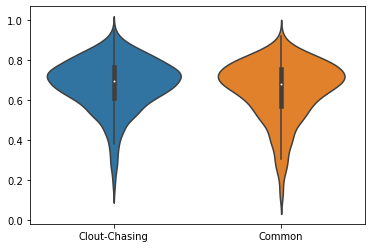

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

simi_df = pd.DataFrame({"Clout-Chasing": simi_res, "Common": simi_res2[0:len(simi_res)]})
sns.violinplot(data=simi_df)
plt.show()